# Project 4: Cd-Aufnahme über die Nahrung bei Folsomia

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pal = sns.color_palette()
from scipy import stats
import pandas as pd
from copy import deepcopy
import pprint
pp = pprint.PrettyPrinter(indent=2)
import os
import pyarrow

current_dir = os.path.dirname(os.path.abspath(''))
project_directory = os.path.dirname(current_dir)

# automatische aktualisierung externer Python-Dateien
%load_ext autoreload
%autoreload 2 

# Einbindung zusätzlicher Funktionen 
from utils import * 
from ModelFitting import *
from mempyDEB.DEBODE.simulators import *
from mempyDEB.DEBODE.defaultparams import *

## DEBFitting


In [2]:
from DEBfitting_Folsomia import *
data = load_data()
data.head()

,t_day,length_mm,C_F,T_cels,S
85,0,0.609,0,20,1.420620
86,2,0.723,0,20,1.999511
87,4,0.857,0,20,2.805551
88,7,1.019,0,20,3.960986
89,9,1.095,0,20,4.571232


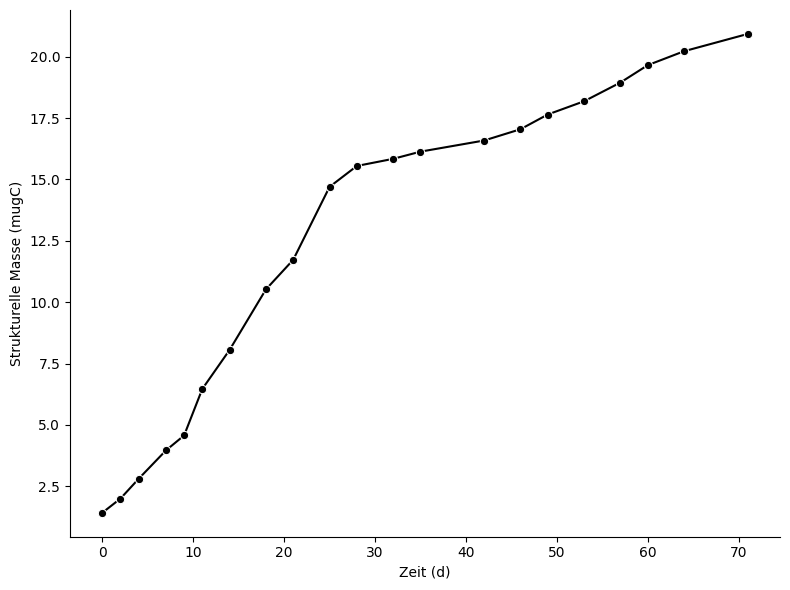

In [3]:
_ = plot_data(data)

c:\Users\Felix\projects\mem25\project\mempyDEB\DEBfitting_Folsomia.py:88: RuntimeWarning: invalid value encountered in scalar power
  p.spc['Idot_max_rel_emb'] *= zoom_factor_theta**(1/3)


Fitted model using Nelder-Mead method. Results stored in `optimization_result`
Estimated parameter values: {'Idot_max_rel': np.float64(4.5483797877675745), 'eta_AS_0': np.float64(0.40638832287776183)}


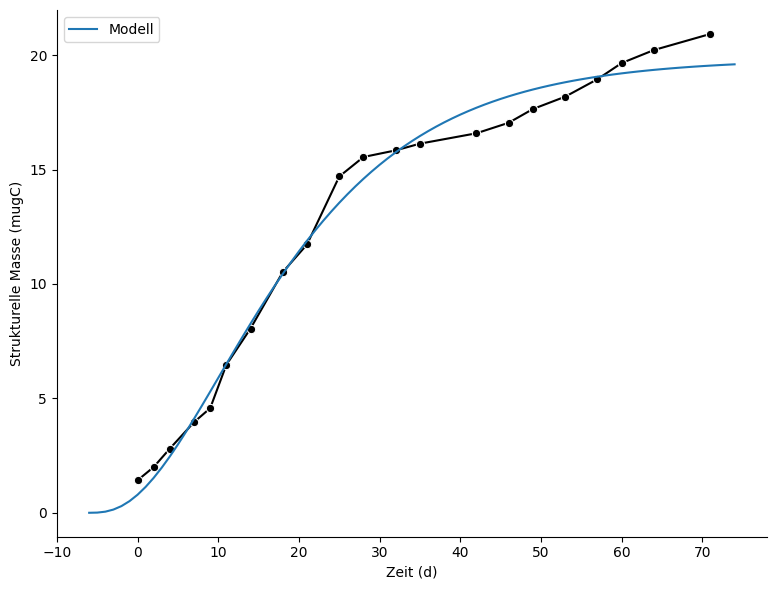

In [4]:
def fit_model_2params():
    """
    DEB-Modellkalibrierung mit zwei Parametern.
    """

    # Definition des ModelFit - Objektes wie zuvor
    f = setup_modelfit() 
    
    # wir müssen hier lediglich den initial guess anpassen
    f.intguess = { 
        'Idot_max_rel' : f.defaultparams.spc['Idot_max_rel'], 
        'eta_AS_0' : f.defaultparams.spc['eta_AS_0']
    }

    # am restlichen Code ändert sich ersmtal nichts

    f.run_optimization()

    print(f"Estimated parameter values: {f.p_opt}")

    # simulate optimized parameters, 

    p = deepcopy(f.defaultparams)
    p.spc.update(f.p_opt)  

    sim_opt = f.simulator(p.spc)

    # plot data + retrodiction

    fig, ax = plot_data(f.data)

    sns.lineplot(sim_opt, x = 't_day', y = 'S', ax = ax, label = "Modell")
    #sns.lineplot(sim_opt, x = 't_day', y = 'cum_repro', ax = ax[1])

    #ax[1].legend()

    return f
 
f_2params = fit_model_2params()

control_fitted_params = f_2params.p_opt


## TKTD Fitting with Cd-intake by food

In [5]:
from TKTDFitting_Folsomia import *
from mempyDEB.DEBODE.simulators import *
from mempyDEB.DEBODE.defaultparams import *

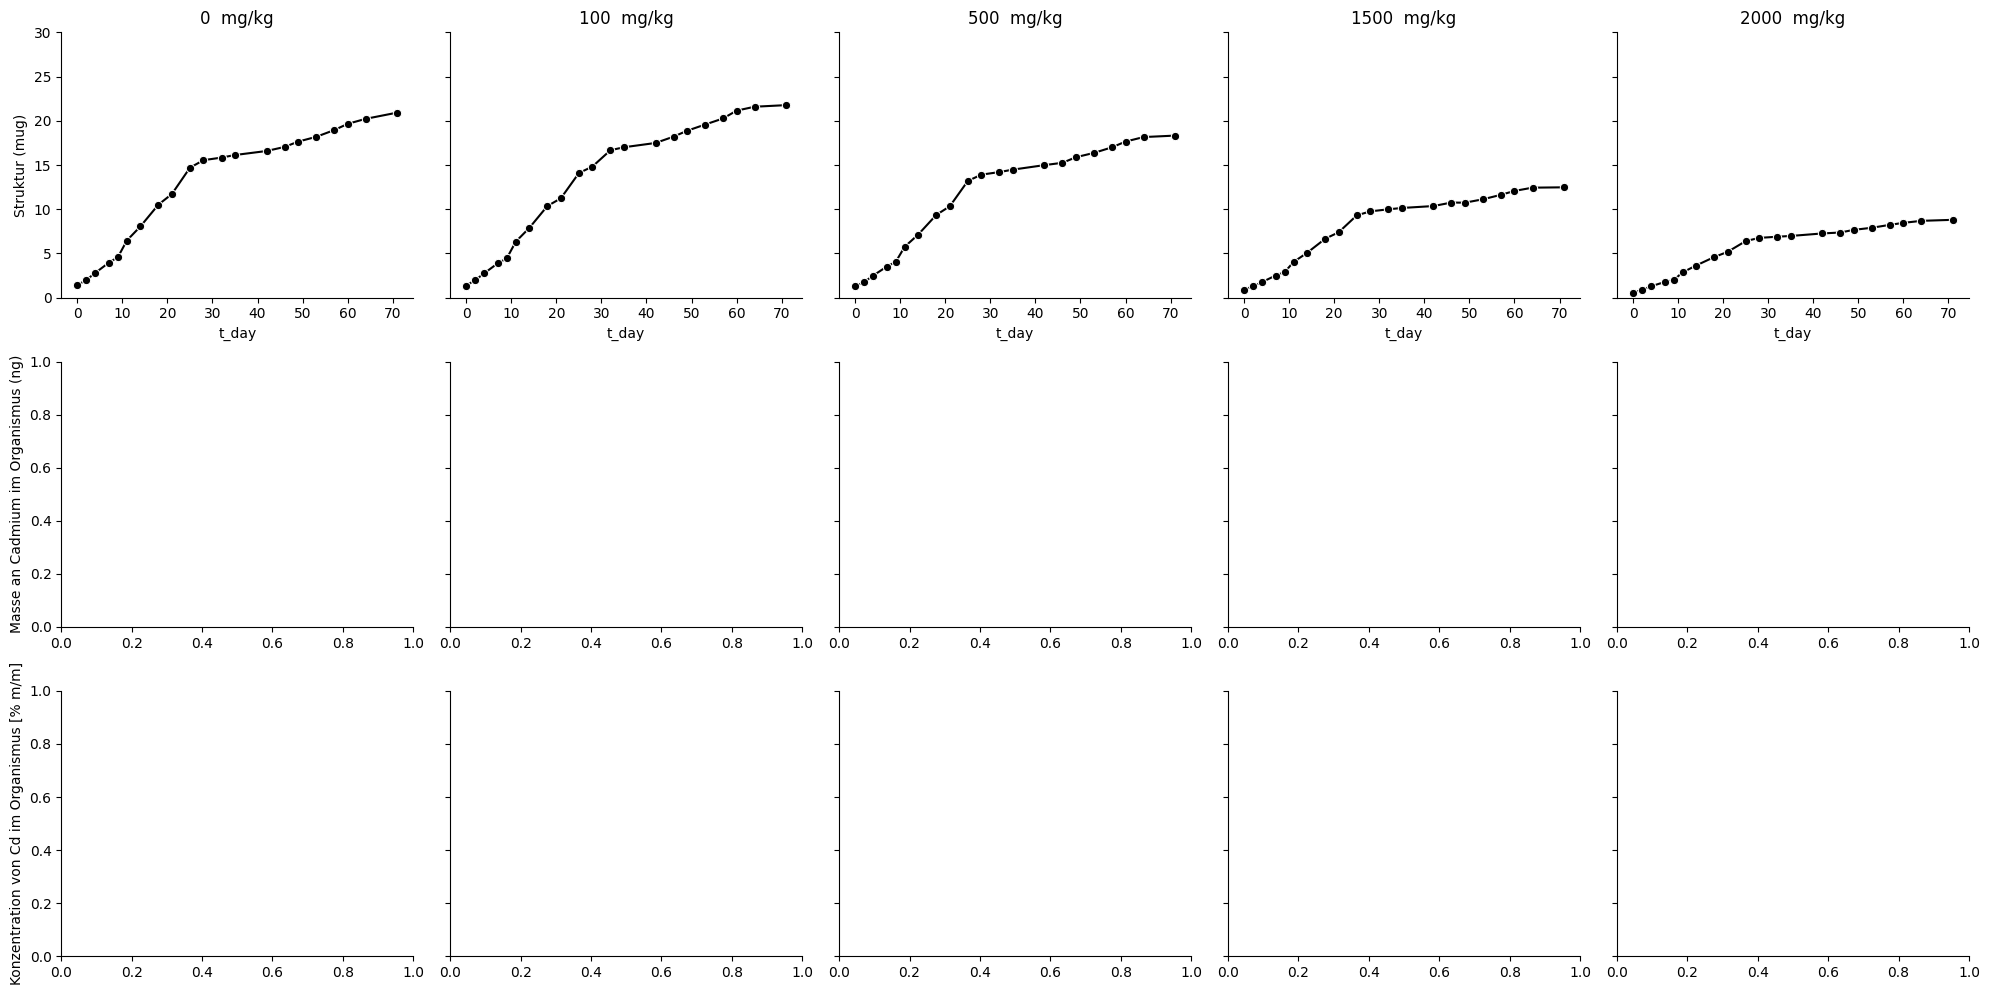

In [6]:
data = load_data()
fig, ax = plot_data(data)


In [ ]:
## no maxiter G

f = setup_modelfit(pmoa = 'G', func = simulate_DEBBase_cd)
f.defaultparams.spc.update(control_fitted_params)
f.intguess = {
        'ED50_j' : 100, 
        'beta_j' : 2, 
        }
sim = f.run_optimization() # führe Kalibrierung mittels lokaler Optimisierung durch

print(f"Estimated parameter values: {f.p_opt}")
# Simulation optimisierter Parameter
p = deepcopy(f.defaultparams)
p.spc.update(f.p_opt)  
sim_opt_G_full_Cd_noexp = f.simulator(p.spc)

# Visual predictive check

fig, ax = plot_data(f.data)
ax = plot_sim(ax, sim_opt_G_full_Cd_noexp)

### runtime 55 secs
### Estimated parameter values: {'ED50_j': np.float64(51.432045351586936), 'beta_j': np.float64(0.8988894694332683)}


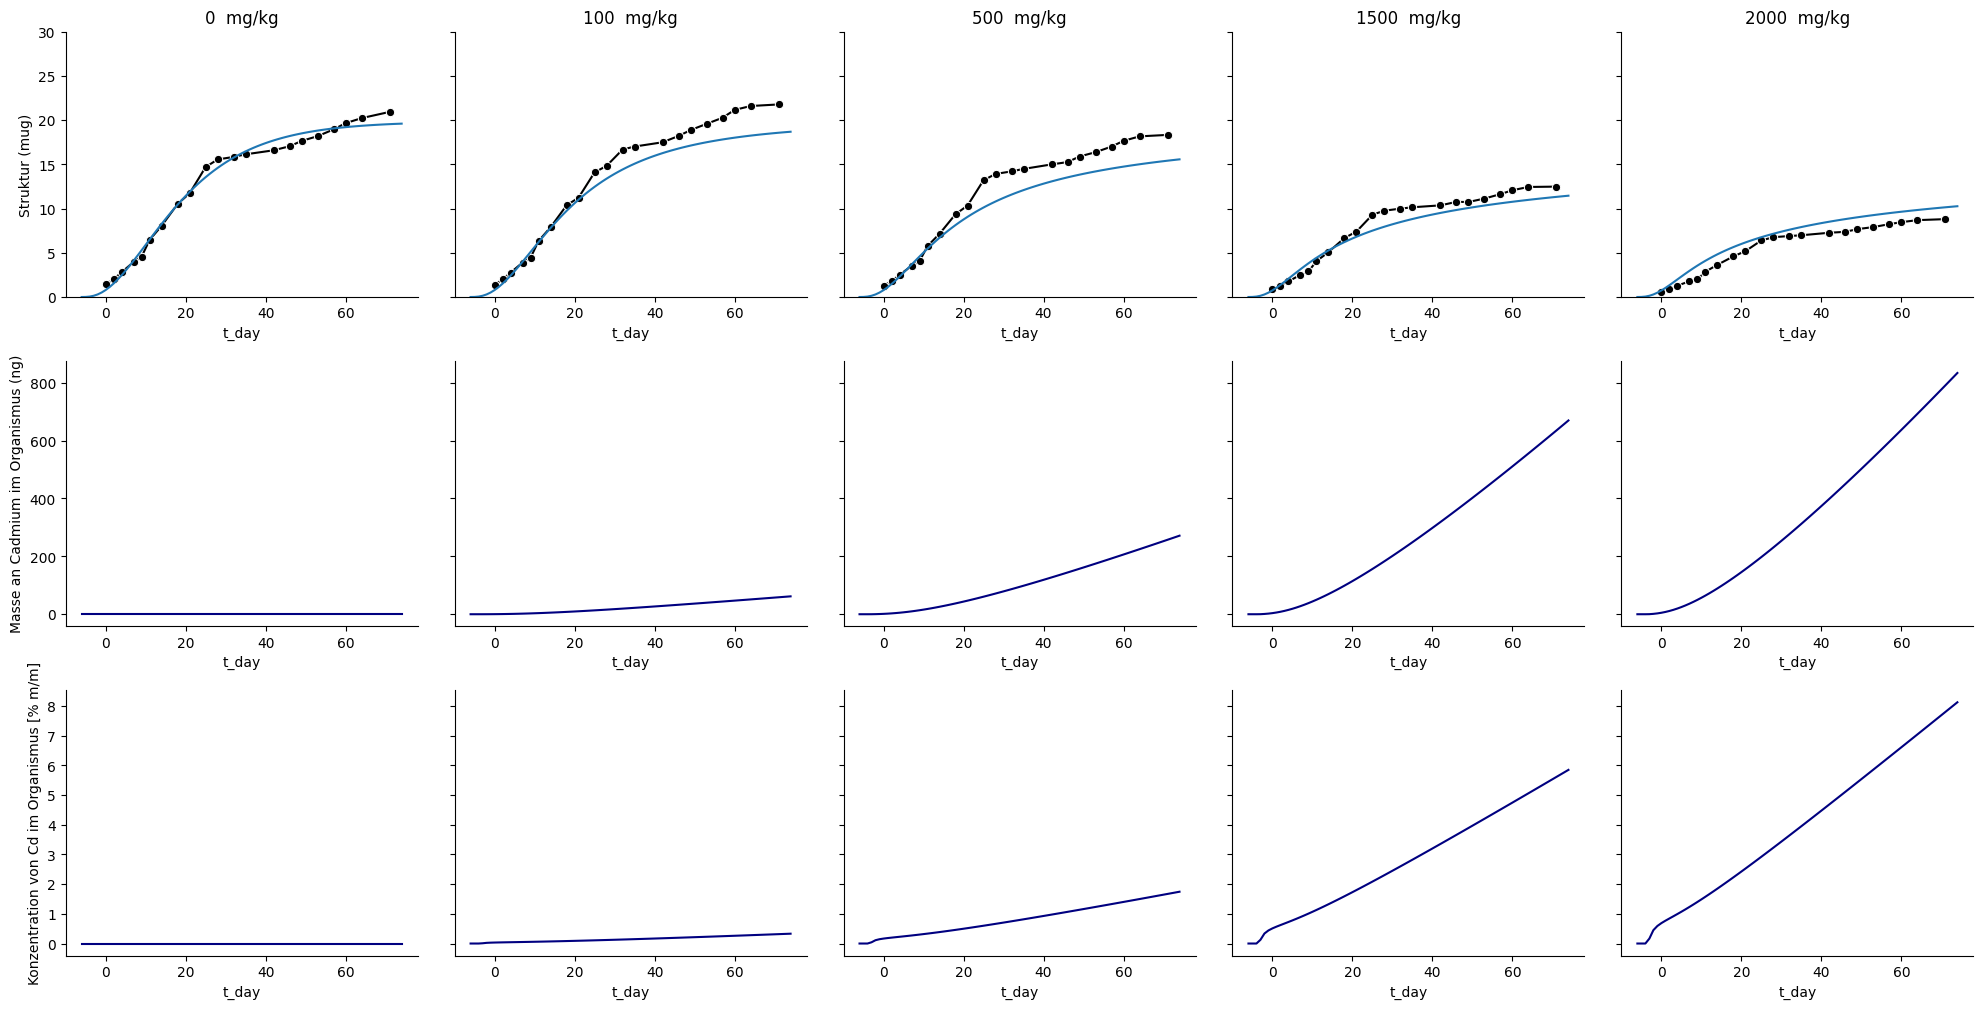

In [45]:
fig, ax = plot_data(f.data)
ax = plot_sim(ax, sim_opt_G_full_Cd_noexp)

In [63]:
f = setup_modelfit(pmoa = 'G', func = simulate_DEBBase_cd)
f.defaultparams.spc.update(control_fitted_params)

intguess = {'ED50_j': np.float64(51.432045351586936), 'beta_j': np.float64(0.8988894694332683)}

sim1 = f.simulator(intguess)

loss = f.loss(sim1, f.data)
loss


np.float64(0.01919540375008688)

In [47]:
sim_opt_G_full_Cd_noexp = sim_opt_G_full_Cd_noexp.assign(cd_conc  = lambda df : df.Cd_in / df.S)
sim_opt_G_full_Cd_noexp

,t_day,C_W,level_2,S,R,X_emb,X,Cd_in,cum_repro,cd_conc,S_ref,R_ref,X_emb_ref,X_ref,Cd_in_ref,C_W_ref,cum_repro_ref,cd_conc_ref,y_S
0,-6,0,0,0.000010,0.000000,9.924165e-01,1.000000e+10,0.000000,0.0,0.000000,0.00001,0.000000,0.992416,1.000000e+10,0.0,0,0.0,0.0,1.000000
1,-6,100,81,0.000010,0.000000,9.924165e-01,1.000000e+10,0.000000,48.0,0.000000,0.00001,0.000000,0.992416,1.000000e+10,0.0,0,0.0,0.0,1.000000
2,-6,500,162,0.000010,0.000000,9.924165e-01,1.000000e+10,0.000000,43.0,0.000000,0.00001,0.000000,0.992416,1.000000e+10,0.0,0,0.0,0.0,1.000000
3,-6,1500,243,0.000010,0.000000,9.924165e-01,1.000000e+10,0.000000,25.0,0.000000,0.00001,0.000000,0.992416,1.000000e+10,0.0,0,0.0,0.0,1.000000
4,-6,2000,324,0.000010,0.000000,9.924165e-01,1.000000e+10,0.000000,0.0,0.000000,0.00001,0.000000,0.992416,1.000000e+10,0.0,0,0.0,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,74,0,80,19.598500,48.949572,-1.128662e-05,7.831235e+11,0.000000,47.0,0.000000,19.59850,48.949572,-0.000011,7.831235e+11,0.0,0,47.0,0.0,1.000000
401,74,100,161,18.683094,44.018380,-1.337129e-05,7.831235e+11,61.792972,42.0,3.307427,19.59850,48.949572,-0.000011,7.831235e+11,0.0,0,47.0,0.0,0.953292
402,74,500,242,15.562912,26.289111,-6.200835e-07,7.831236e+11,271.429178,24.0,17.440771,19.59850,48.949572,-0.000011,7.831235e+11,0.0,0,47.0,0.0,0.794087
403,74,1500,323,11.451830,0.000000,-1.354102e-08,7.831236e+11,669.595251,0.0,58.470590,19.59850,48.949572,-0.000011,7.831235e+11,0.0,0,47.0,0.0,0.584322


In [62]:
## no maxiter A

f = setup_modelfit(pmoa = 'A', func = simulate_DEBBase_cd)
f.defaultparams.spc.update(control_fitted_params)
f.intguess = {
        'ED50_j' : 100, 
        'beta_j' : 2, 
        }
sim = f.run_optimization(bounds = [(0, 1000), (0, 1000)],
                         options={'maxiter' : 2}) # führe Kalibrierung mittels lokaler Optimisierung durch

print(f"Estimated parameter values: {f.p_opt}")
# Simulation optimisierter Parameter
p = deepcopy(f.defaultparams)
p.spc.update(f.p_opt)  
sim_opt_A_full_Cd_noexp = f.simulator(p.spc)

# Visual predictive check

fig, ax = plot_data(f.data)
ax = plot_sim(ax, sim_opt_A_full_Cd_noexp)

### runtime forever secs
### Estimated parameter values: none

KeyboardInterrupt: 

## TKTD Fitting Cd-intake and Cd-export


In [7]:
from TKTDFitting_Folsomia import *
from mempyDEB.DEBODE.simulators import *
from mempyDEB.DEBODE.defaultparams import *

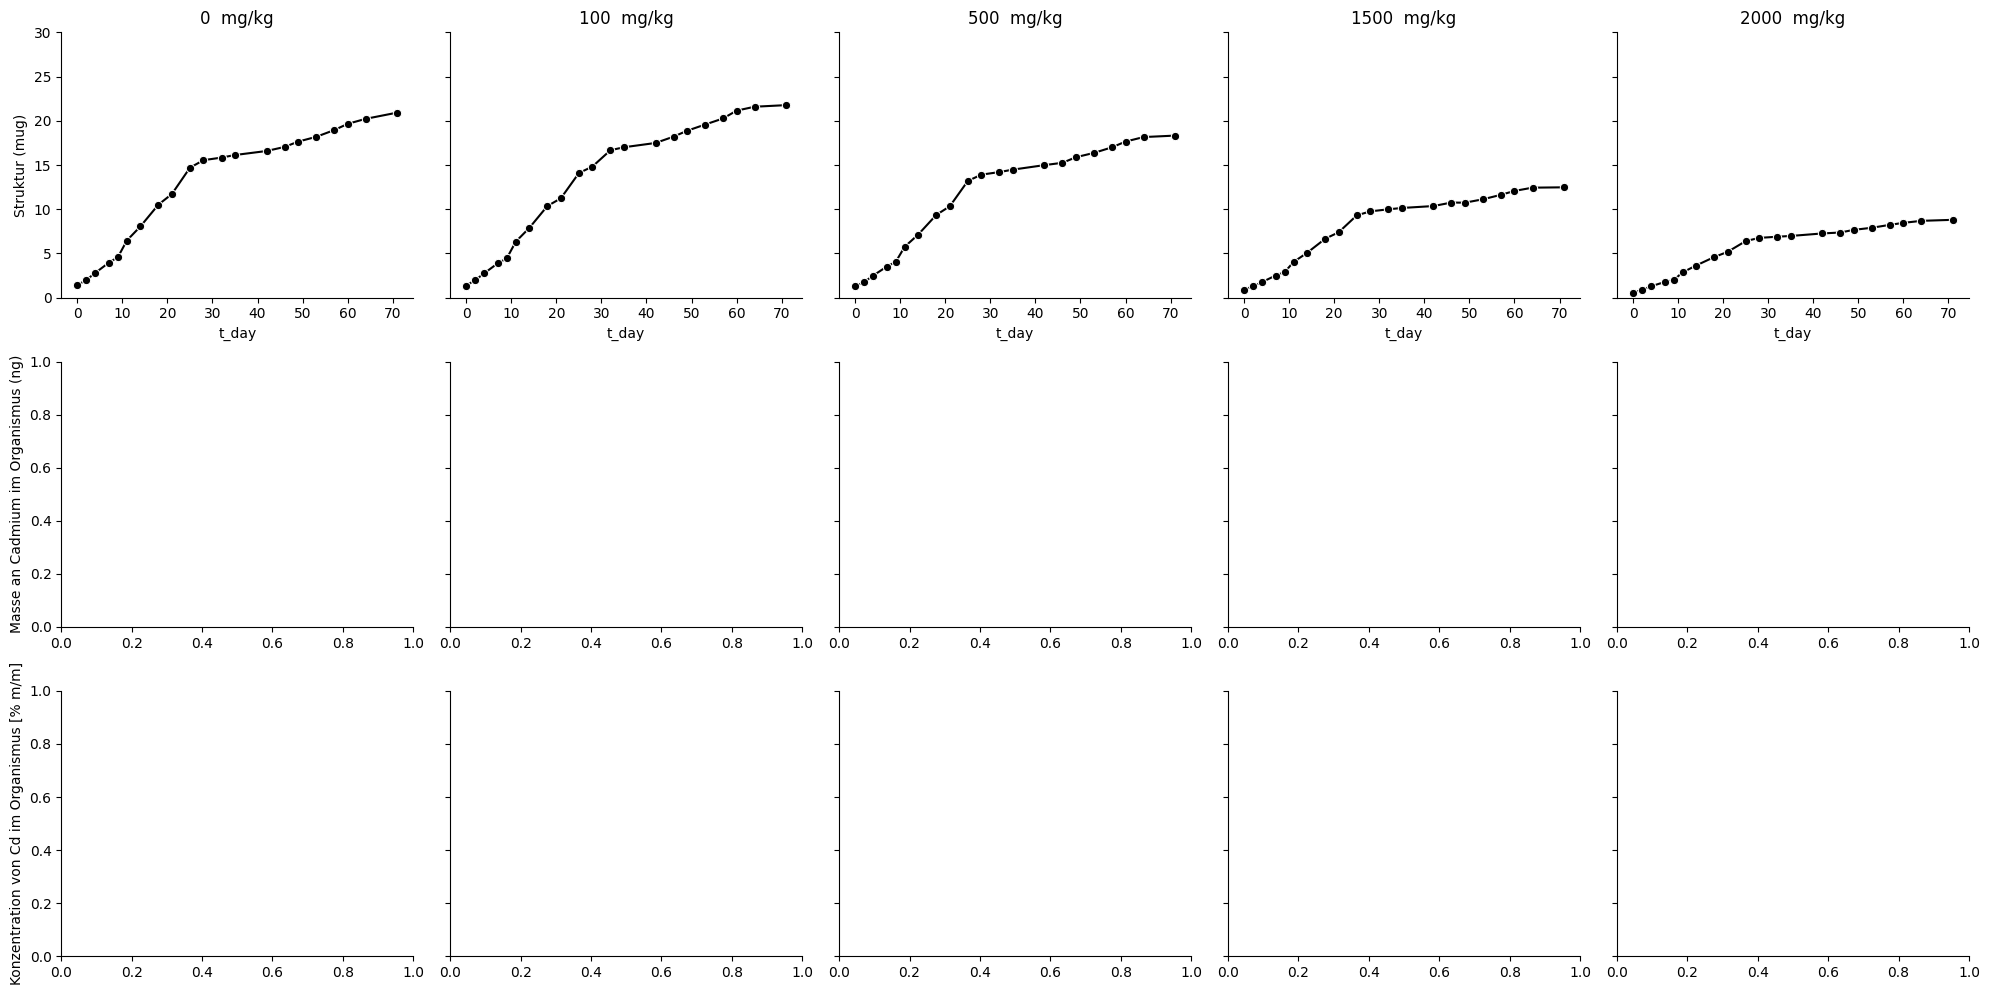

In [8]:
data = load_data()
fig, ax = plot_data(data)


### checking out loss values depending on various varied parameters

[np.float64(0.1571133271421053), np.float64(0.15915390699109527), np.float64(0.16168055287454206), np.float64(0.16482802403099925), np.float64(0.16877932919808628), np.float64(0.17378870262459378), np.float64(0.180217407038767), np.float64(0.18859045925493612), np.float64(0.19968767953378397), np.float64(0.21468798222307725), np.float64(0.23539258351313222), np.float64(0.26454619208469604), np.float64(0.30623210326342554), np.float64(0.3661750583106373), np.float64(0.45149215686197425), np.float64(0.5690747811503961), np.float64(0.7219067996907895), np.float64(0.9041226564572193), np.float64(1.0982554307349792), np.float64(1.2786603602284117), np.float64(1.4202757801814625), np.float64(1.5064412072218416), np.float64(1.53139884801248), np.float64(1.4987737023921972), np.float64(1.4186014523279145), np.float64(1.303847186663316), np.float64(1.1672652130949157), np.float64(1.0196483160551684), np.float64(0.8694864346726002), np.float64(0.7233774753226938), np.float64(0.5861479143382194),

Text(0.5, 0, 'ED50, beta_j')

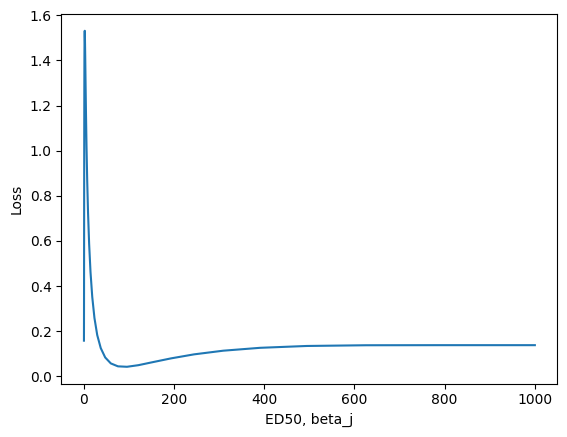

In [12]:
x = np.geomspace(0.01, 1000)
arr = []
f = setup_modelfit()
f.defaultparams.spc.update(control_fitted_params)
for i in x:
    f.intguess = {
            'ED50_j' : i,
            'beta_j' : i,
            }
    sim = f.simulator(f.intguess)
    arr.append(f.loss(sim, f.data))

print(arr)
fig, ax = plt.subplots()
ax.plot(x, arr)
ax.set_ylabel('Loss')
ax.set_xlabel('ED50, beta_j')



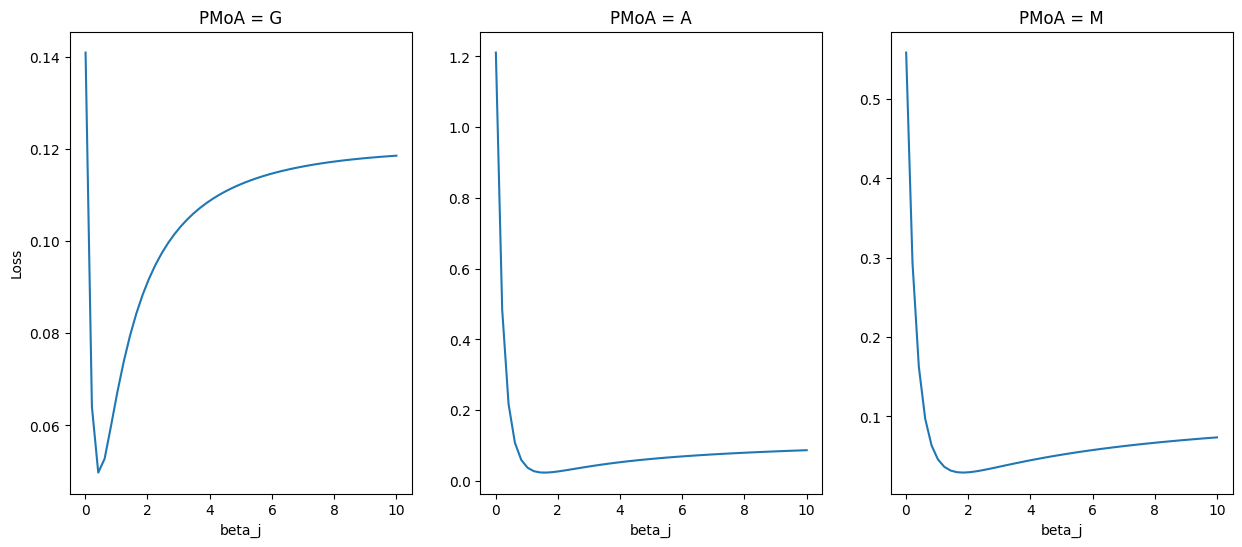

In [9]:
PMOAs = ['G', 'A', 'M']
fig, ax = plt.subplots(ncols= 3, nrows = 1, figsize = (15, 6))


for index, Pmoa in enumerate(PMOAs):
    
    # x = np.geomspace(1, np.median(EXPOSURES))
    x = np.linspace(0.01, 10, 50)
    #x = np.geomspace(0.01, 1000)
    arr = []
    f = setup_modelfit(pmoa=Pmoa)
    f.defaultparams.spc.update(control_fitted_params)
    for i in x:
        f.intguess = {
                'ED50_j' : 2,
                'beta_j' : i,
                'ex_cd' : 9
                }
        sim = f.simulator(f.intguess)
        arr.append(f.loss(sim, f.data))

    ax[index].plot(x, arr)
    ax[index].set_title(f'PMoA = {Pmoa}')
    ax[0].set_ylabel(f'Loss')
    ax[index].set_xlabel(f'beta_j')



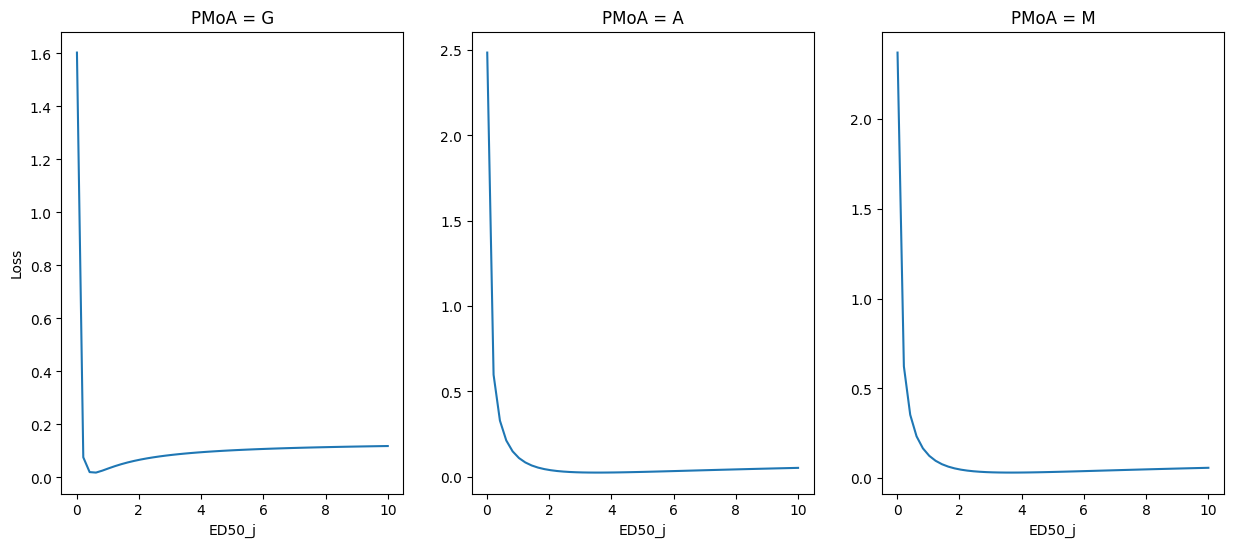

In [10]:
PMOAs = ['G', 'A', 'M']
fig, ax = plt.subplots(ncols= 3, nrows = 1, figsize = (15, 6))

for index, Pmoa in enumerate(PMOAs):
    
    # x = np.geomspace(1, np.median(EXPOSURES))
    x = np.linspace(0.01, 10, 50)
    #x = np.geomspace(0.01, 1000)
    arr = []
    f = setup_modelfit(pmoa=Pmoa)
    f.defaultparams.spc.update(control_fitted_params)
    for i in x:
        f.intguess = {
                'ED50_j' : i,
                'beta_j' : 1,
                'ex_cd' : 9
                }
        sim = f.simulator(f.intguess)
        arr.append(f.loss(sim, f.data))

    ax[index].plot(x, arr)
    ax[index].set_title(f'PMoA = {Pmoa}')
    ax[0].set_ylabel(f'Loss')
    ax[index].set_xlabel(f'ED50_j')


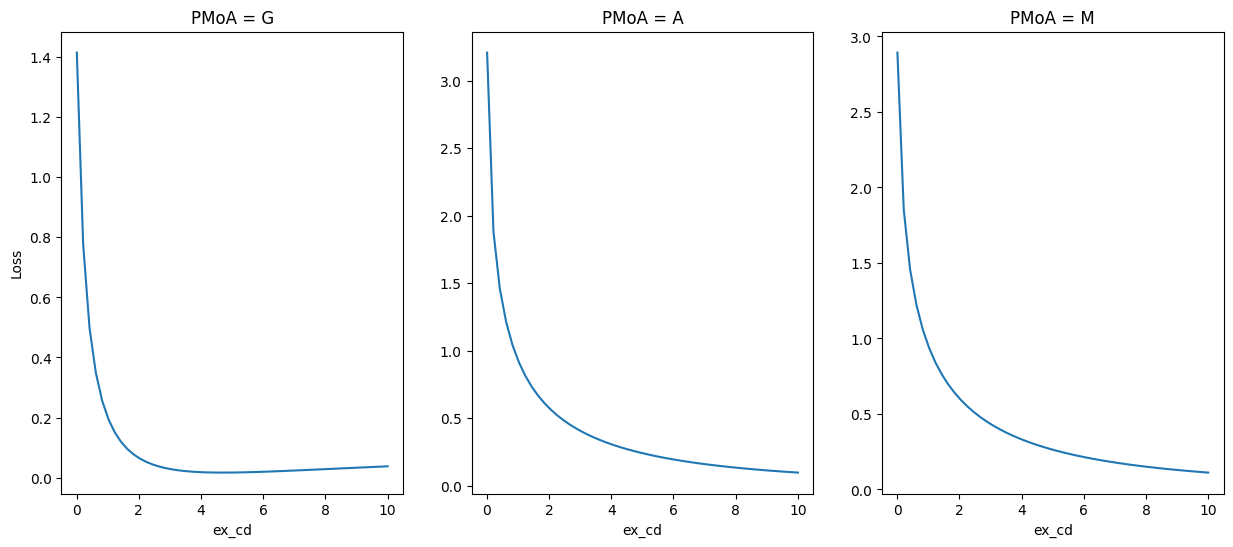

In [11]:
PMOAs = ['G', 'A', 'M']
fig, ax = plt.subplots(ncols= 3, nrows = 1, figsize = (15, 6))


for index, Pmoa in enumerate(PMOAs):
    
    # x = np.geomspace(1, np.median(EXPOSURES))
    x = np.linspace(0.01, 10, 50)
    #x = np.geomspace(0.01, 1000)
    arr = []
    f = setup_modelfit(pmoa=Pmoa)
    f.defaultparams.spc.update(control_fitted_params)
    for i in x:
        f.intguess = {
                'ED50_j' : 1,
                'beta_j' : 1,
                'ex_cd' : i
                }
        sim = f.simulator(f.intguess)
        arr.append(f.loss(sim, f.data))

    ax[index].plot(x, arr)
    ax[index].set_title(f'PMoA = {Pmoa}')
    ax[0].set_ylabel(f'Loss')
    ax[index].set_xlabel(f'ex_cd')

### Modelfitting for PMoA: G

Fitted model using Nelder-Mead method. Results stored in `optimization_result`
Estimated parameter values: {'ex_cd': np.float64(0.02187037037037036), 'ED50_j': np.float64(68.51851851851859), 'beta_j': np.float64(2.3333333333333313)}


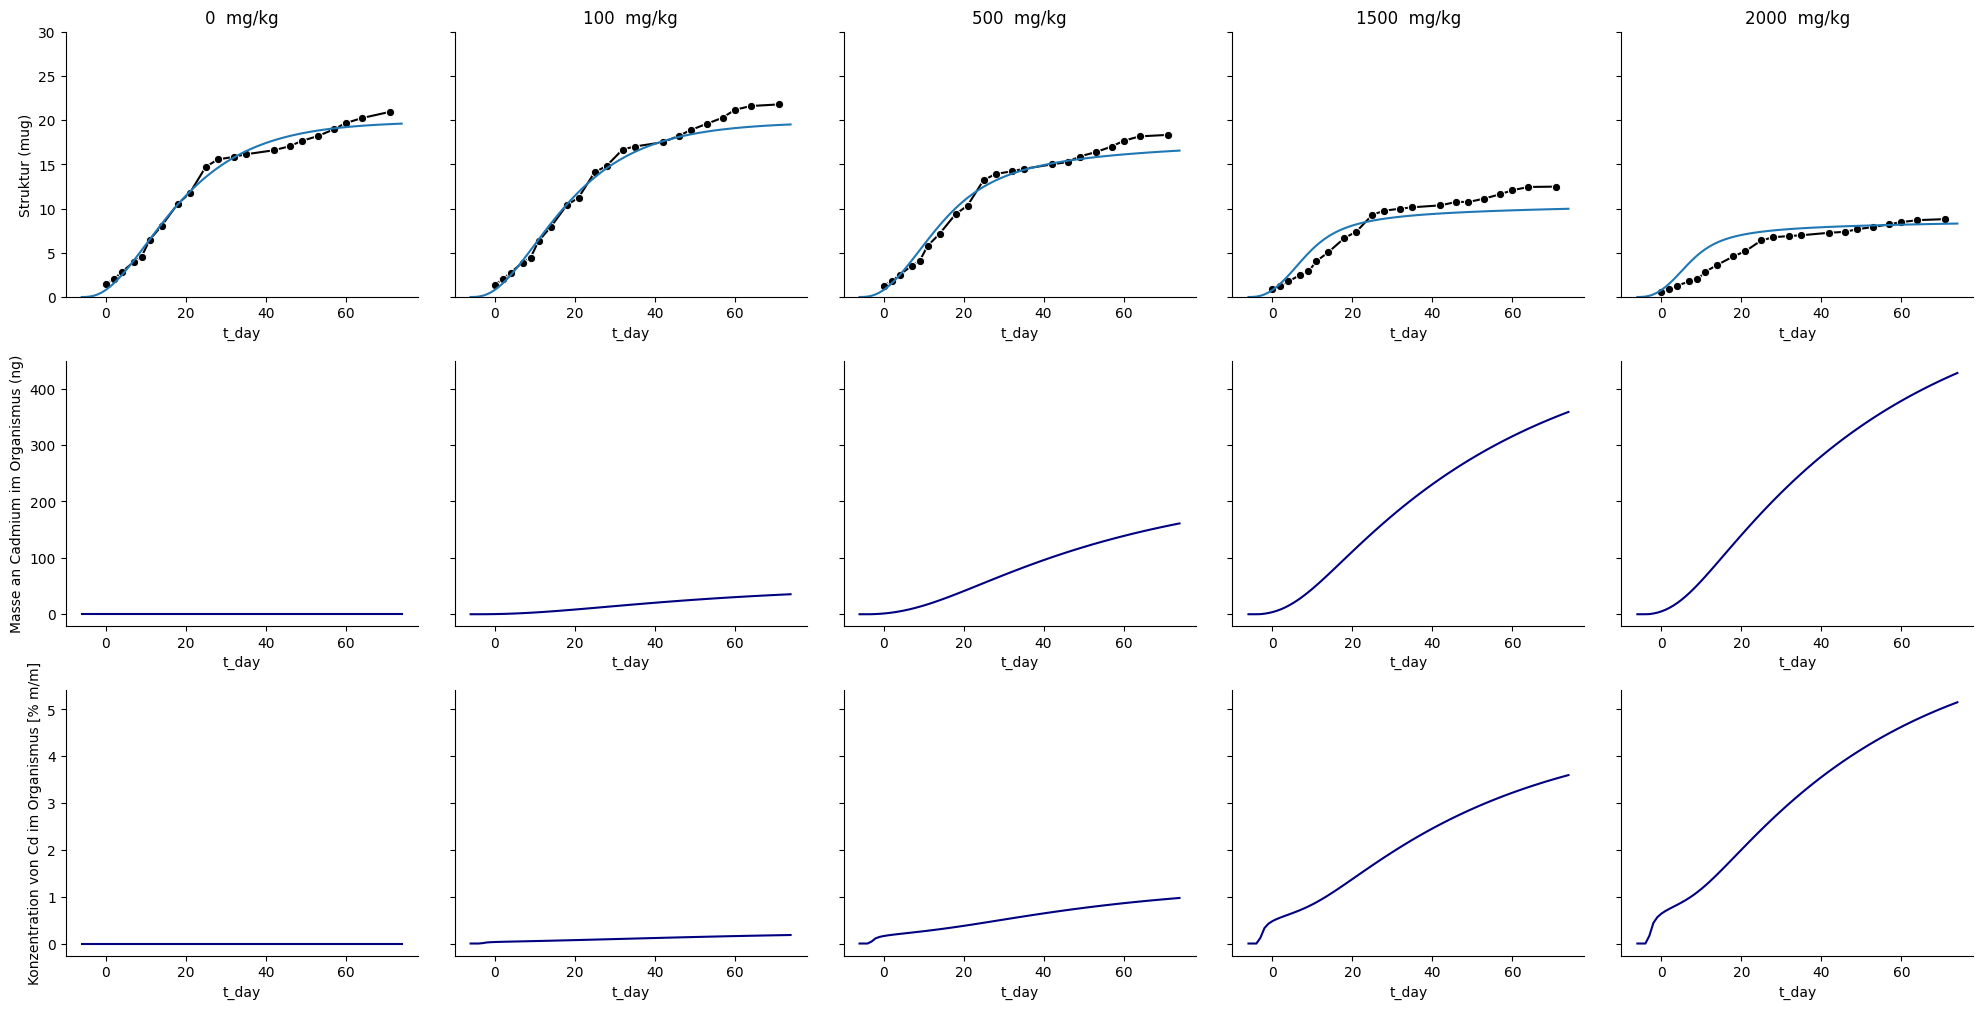

In [90]:
## maxiter 10

f = setup_modelfit(pmoa = 'G', func = simulate_DEBBase_cd_export)
f.defaultparams.spc.update(control_fitted_params)
f.intguess = {
        'ex_cd': 0.02,
        'ED50_j' : 100, 
        'beta_j' : 2, 
        }
sim = f.run_optimization(options={'maxiter' : 10}) # führe Kalibrierung mittels lokaler Optimisierung durch

print(f"Estimated parameter values: {f.p_opt}")
# Simulation optimisierter Parameter
p = deepcopy(f.defaultparams)
p.spc.update(f.p_opt)  
sim_opt = f.simulator(p.spc)

# Visual predictive check

fig, ax = plot_data(f.data)
ax = plot_sim(ax, sim_opt)

Fitted model using Nelder-Mead method. Results stored in `optimization_result`
Estimated parameter values: {'ex_cd': np.float64(0.4786352670858547), 'ED50_j': np.float64(9.31399643662337), 'beta_j': np.float64(1.5811202242472335)}


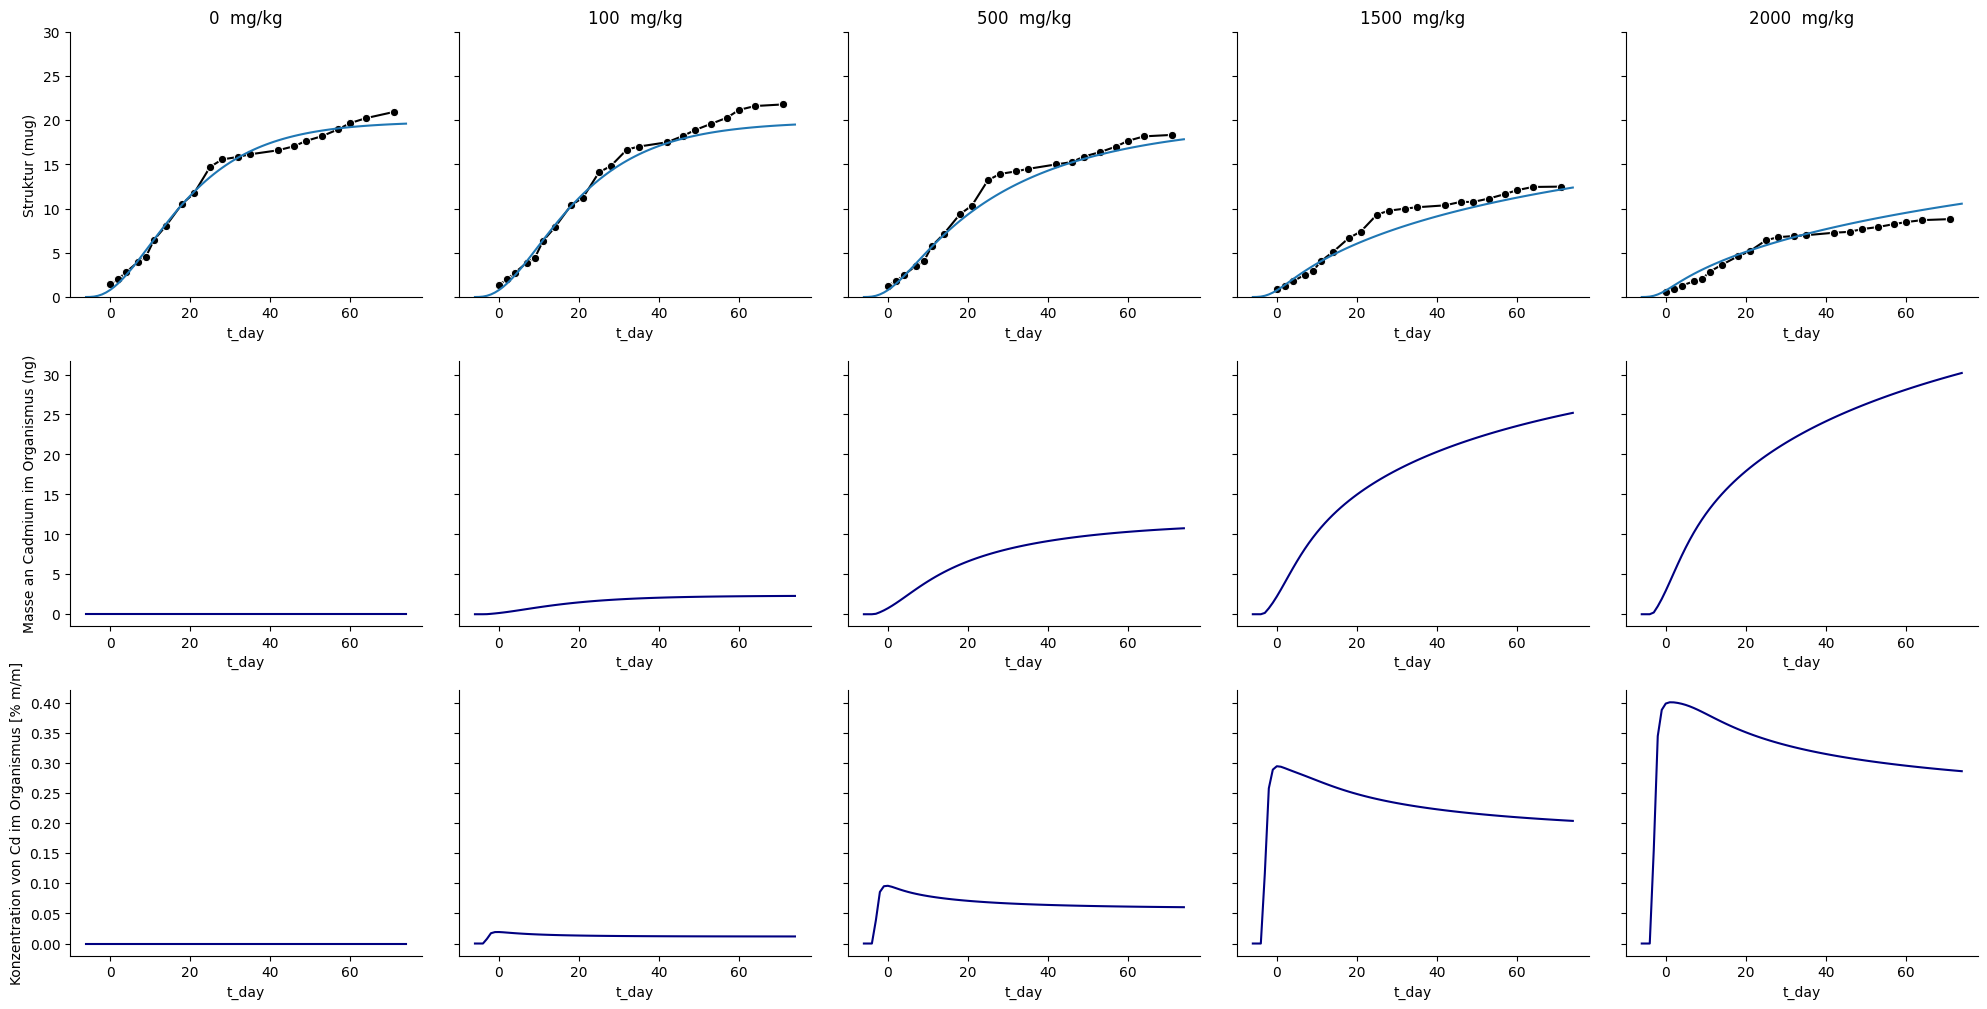

In [70]:
## maxiter 100

f = setup_modelfit(pmoa = 'G', func = simulate_DEBBase_cd_export)
f.defaultparams.spc.update(control_fitted_params)
f.intguess = {
        'ex_cd': 0.02,
        'ED50_j' : 100, 
        'beta_j' : 2, 
        }
sim = f.run_optimization(options={'maxiter' : 100}) # führe Kalibrierung mittels lokaler Optimisierung durch

print(f"Estimated parameter values: {f.p_opt}")
# Simulation optimisierter Parameter
p = deepcopy(f.defaultparams)
p.spc.update(f.p_opt)  
sim_opt = f.simulator(p.spc)

# Visual predictive check

fig, ax = plot_data(f.data)
ax = plot_sim(ax, sim_opt)

Fitted model using Nelder-Mead method. Results stored in `optimization_result`
Estimated parameter values: {'ex_cd': np.float64(8.345614771938182), 'ED50_j': np.float64(0.6246365419395792), 'beta_j': np.float64(1.8587573162963613)}


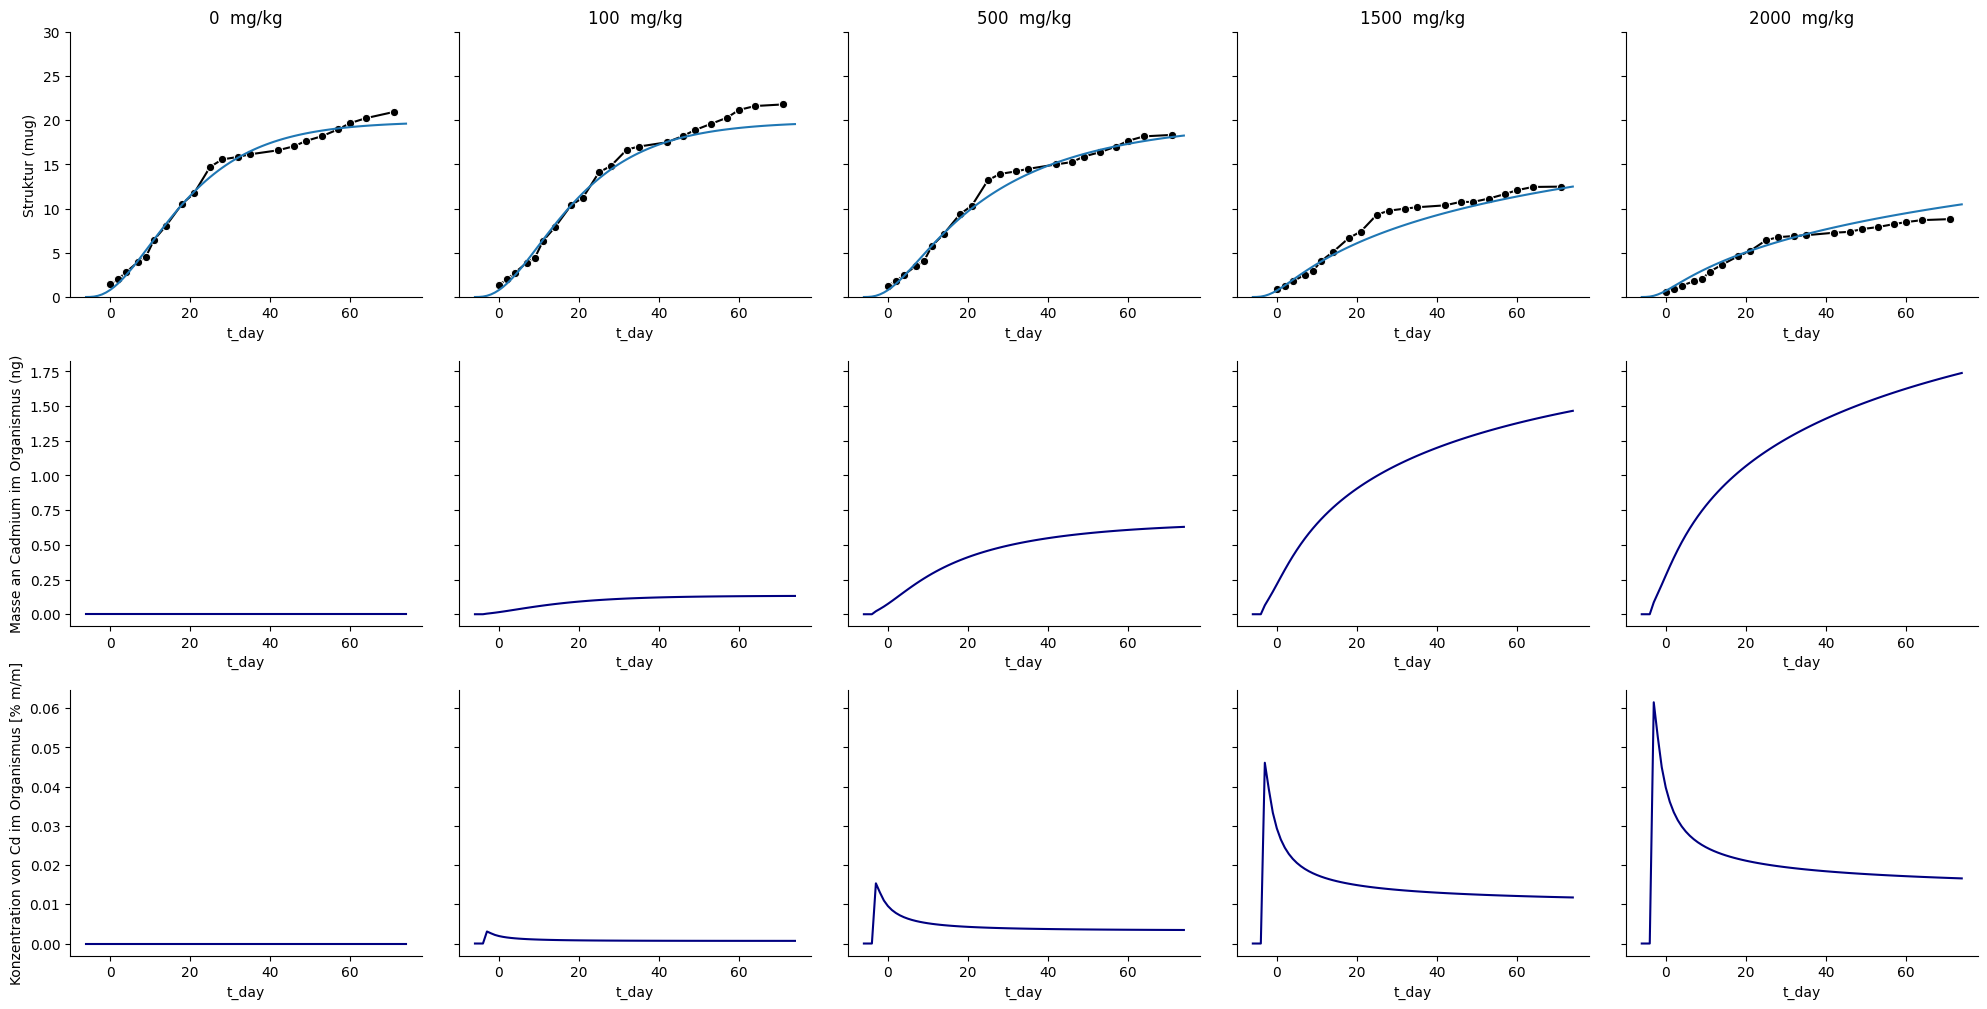

In [ ]:
## no maxiter

f = setup_modelfit(pmoa = 'G', func = simulate_DEBBase_cd_export)
f.defaultparams.spc.update(control_fitted_params)
f.intguess = {
        'ex_cd': 0.02,
        'ED50_j' : 100, 
        'beta_j' : 2, 
        }
sim = f.run_optimization() # führe Kalibrierung mittels lokaler Optimisierung durch

print(f"Estimated parameter values: {f.p_opt}")
# Simulation optimisierter Parameter
p = deepcopy(f.defaultparams)
p.spc.update(f.p_opt)  
sim_opt_G_full = f.simulator(p.spc)

# Visual predictive check

fig, ax = plot_data(f.data)
ax = plot_sim(ax, sim_opt_G_full)

### runtime 5:40
### Estimated parameter values: {'ex_cd': np.float64(8.345614771938182), 'ED50_j': np.float64(0.6246365419395792), 'beta_j': np.float64(1.8587573162963613)}

Fitted model using Nelder-Mead method. Results stored in `optimization_result`
Estimated parameter values: {'ex_cd': np.float64(1.0), 'ED50_j': np.float64(4.923670231743268), 'beta_j': np.float64(1.7459337516334563)}


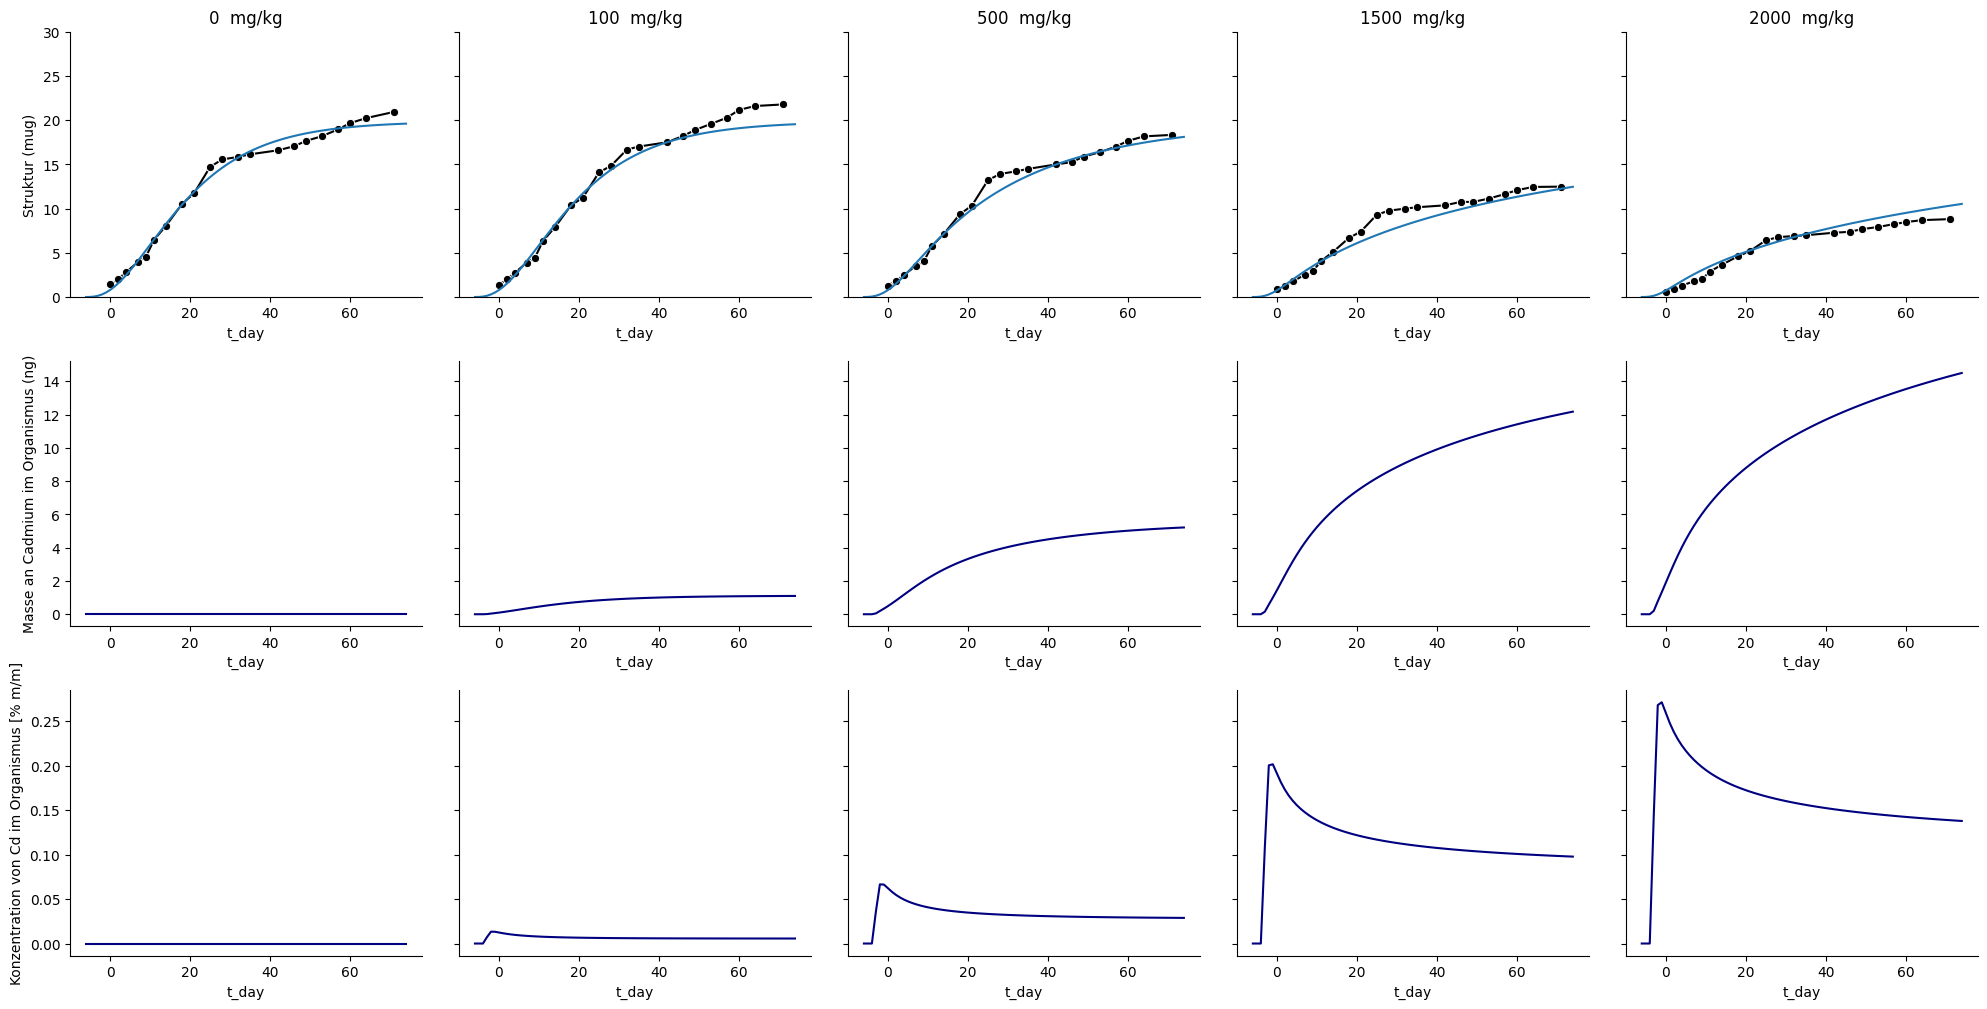

In [ ]:
## no maxiter WITH BOUNDED EX_CD TO MAX OF 1

f = setup_modelfit(pmoa = 'G', func = simulate_DEBBase_cd_export)
f.defaultparams.spc.update(control_fitted_params)
f.intguess = {
        'ex_cd': 0.02,
        'ED50_j' : 100, 
        'beta_j' : 2, 
        }
sim = f.run_optimization(bounds = [(0,1), (0,1000), (0,1000)]) # führe Kalibrierung mittels lokaler Optimisierung durch

print(f"Estimated parameter values: {f.p_opt}")
# Simulation optimisierter Parameter
p = deepcopy(f.defaultparams)
p.spc.update(f.p_opt)  
sim_opt_G_full = f.simulator(p.spc)

# Visual predictive check

fig, ax = plot_data(f.data)
ax = plot_sim(ax, sim_opt_G_full)

### runtime 3:02
### Estimated parameter values: {'ex_cd': np.float64(1.0), 'ED50_j': np.float64(4.923670231743268), 'beta_j': np.float64(1.7459337516334563)}

Fitted model using Nelder-Mead method. Results stored in `optimization_result`
Estimated parameter values: {'ex_cd': np.float64(0.1), 'ED50_j': np.float64(27.767323114605347), 'beta_j': np.float64(1.1969682573928746)}


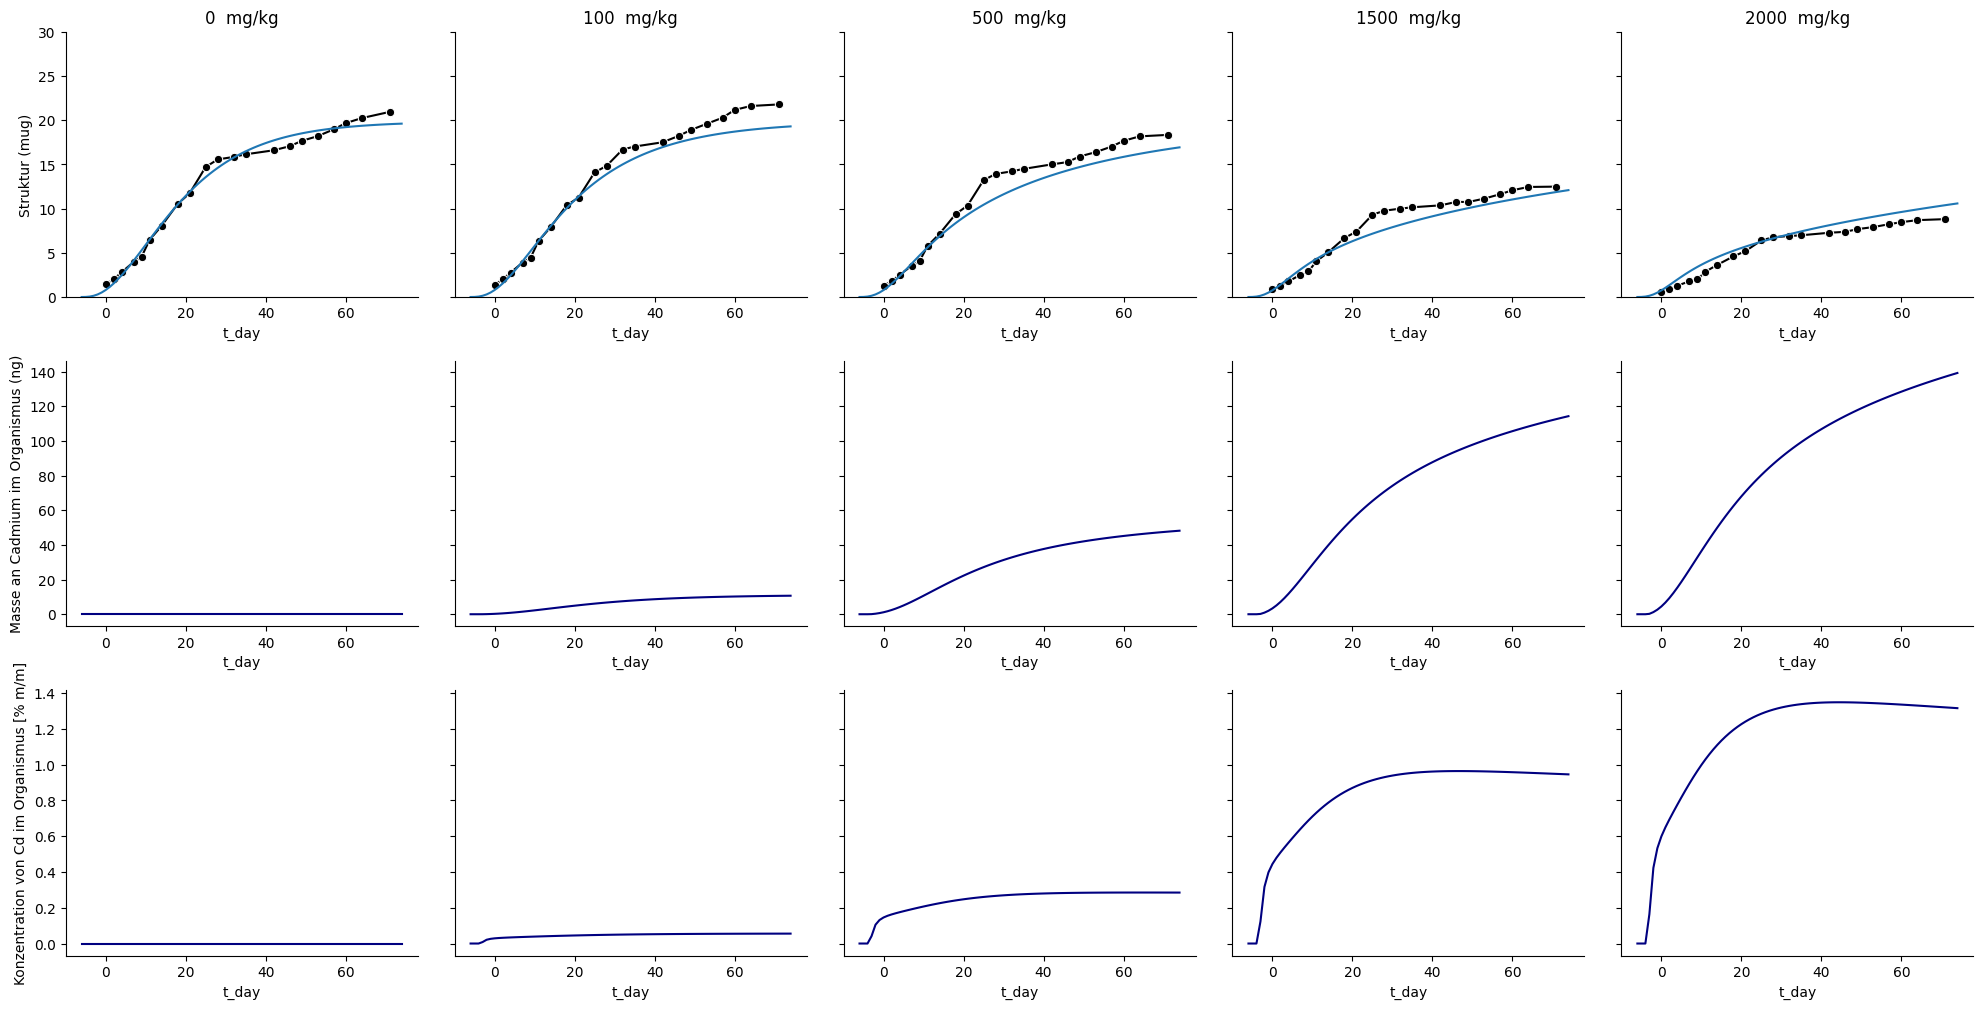

In [ ]:
## no maxiter WITH BOUNDED EX_CD TO MAX OF 0.1

f = setup_modelfit(pmoa = 'G', func = simulate_DEBBase_cd_export)
f.defaultparams.spc.update(control_fitted_params)
f.intguess = {
        'ex_cd': 0.02,
        'ED50_j' : 100, 
        'beta_j' : 2, 
        }
sim = f.run_optimization(bounds = [(0,0.1), (0,1000), (0,1000)]) # führe Kalibrierung mittels lokaler Optimisierung durch

print(f"Estimated parameter values: {f.p_opt}")
# Simulation optimisierter Parameter
p = deepcopy(f.defaultparams)
p.spc.update(f.p_opt)  
sim_opt_G_full_bounded = f.simulator(p.spc)

# Visual predictive check

fig, ax = plot_data(f.data)
ax = plot_sim(ax, sim_opt_G_full)

### runtime 1:59
### Estimated parameter values: {'ex_cd': np.float64(0.1), 'ED50_j': np.float64(27.767323114605347), 'beta_j': np.float64(1.1969682573928746)}

The more we bound ex_Cd, the more the system reacts by increasing ED50. This results in a worse fit but in more realistic endpoint concentrations for Cd in the organism.

In [79]:
f = setup_modelfit(pmoa = 'G', func = simulate_DEBBase_cd_export)
f.defaultparams.spc.update(control_fitted_params)

intguess = {'ex_cd': np.float64(0.1), 'ED50_j': np.float64(27.767323114605347), 'beta_j': np.float64(1.1969682573928746)}
sim2 = f.simulator(intguess)

loss = f.loss(sim2, f.data)
loss

np.float64(0.015516335211589039)

In [66]:
f = setup_modelfit(pmoa = 'G', func = simulate_DEBBase_cd_export)
f.defaultparams.spc.update(control_fitted_params)

intguess = {'ex_cd': np.float64(8.345614771938182), 'ED50_j': np.float64(0.6246365419395792), 'beta_j': np.float64(1.8587573162963613)}

sim2 = f.simulator(intguess)

loss = f.loss(sim2, f.data)
loss


np.float64(0.010520914156958069)

### Modelfitting for PMoA: A

Fitted model using Nelder-Mead method. Results stored in `optimization_result`
Estimated parameter values: {'ex_cd': np.float64(2.383333333333331), 'ED50_j': np.float64(2.0055555555555475), 'beta_j': np.float64(0.8999999999999861)}


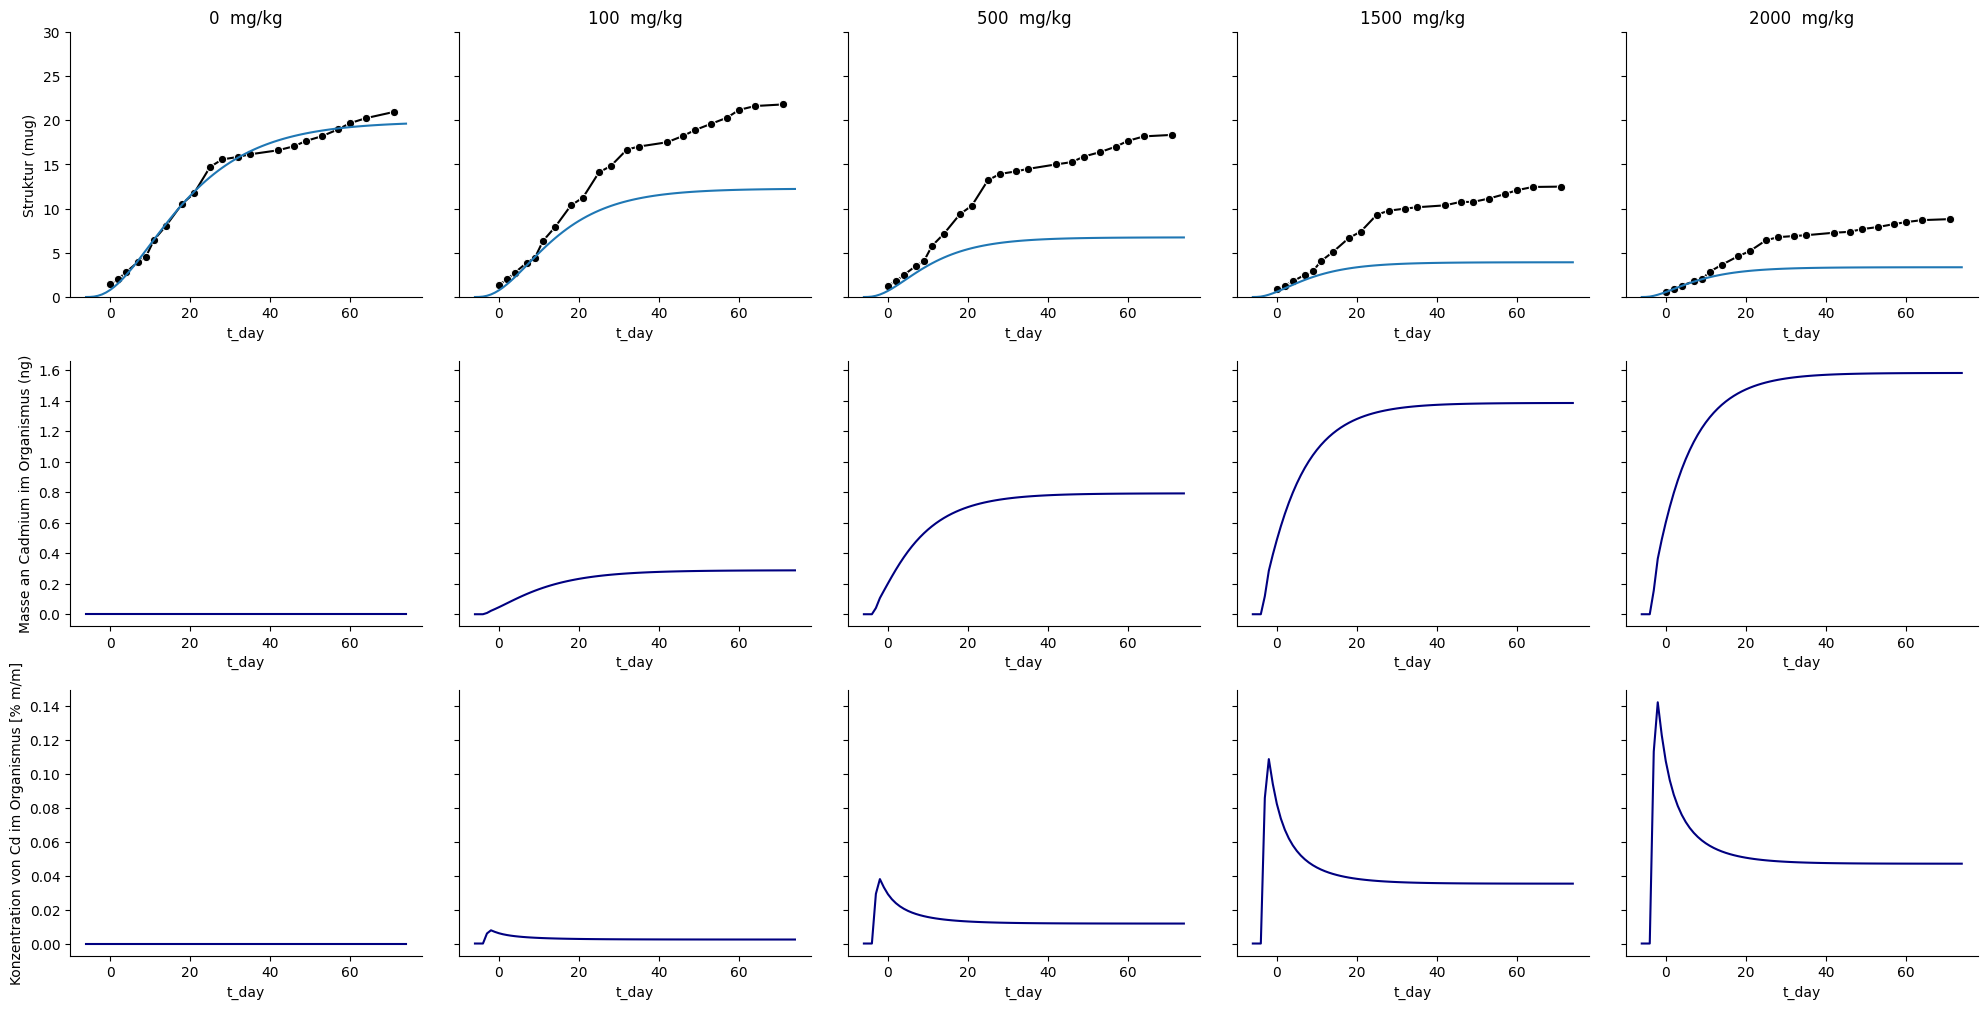

In [72]:
## maxiter 10

f = setup_modelfit(pmoa = 'A', func = simulate_DEBBase_cd_export)
f.defaultparams.spc.update(control_fitted_params)
f.intguess = {
        'ex_cd': 1,
        'ED50_j' : 1, 
        'beta_j' : 2, 
        }
sim = f.run_optimization(options={'maxiter' : 10} ) # führe Kalibrierung mittels lokaler Optimisierung durch

print(f"Estimated parameter values: {f.p_opt}")
# Simulation optimisierter Parameter
p = deepcopy(f.defaultparams)
p.spc.update(f.p_opt)  
sim_opt = f.simulator(p.spc)

# Visual predictive check

fig, ax = plot_data(f.data)
ax = plot_sim(ax, sim_opt)

Fitted model using Nelder-Mead method. Results stored in `optimization_result`
Estimated parameter values: {'ex_cd': np.float64(9.56903252366271), 'ED50_j': np.float64(2.1720652352704573), 'beta_j': np.float64(1.3681009318068602)}


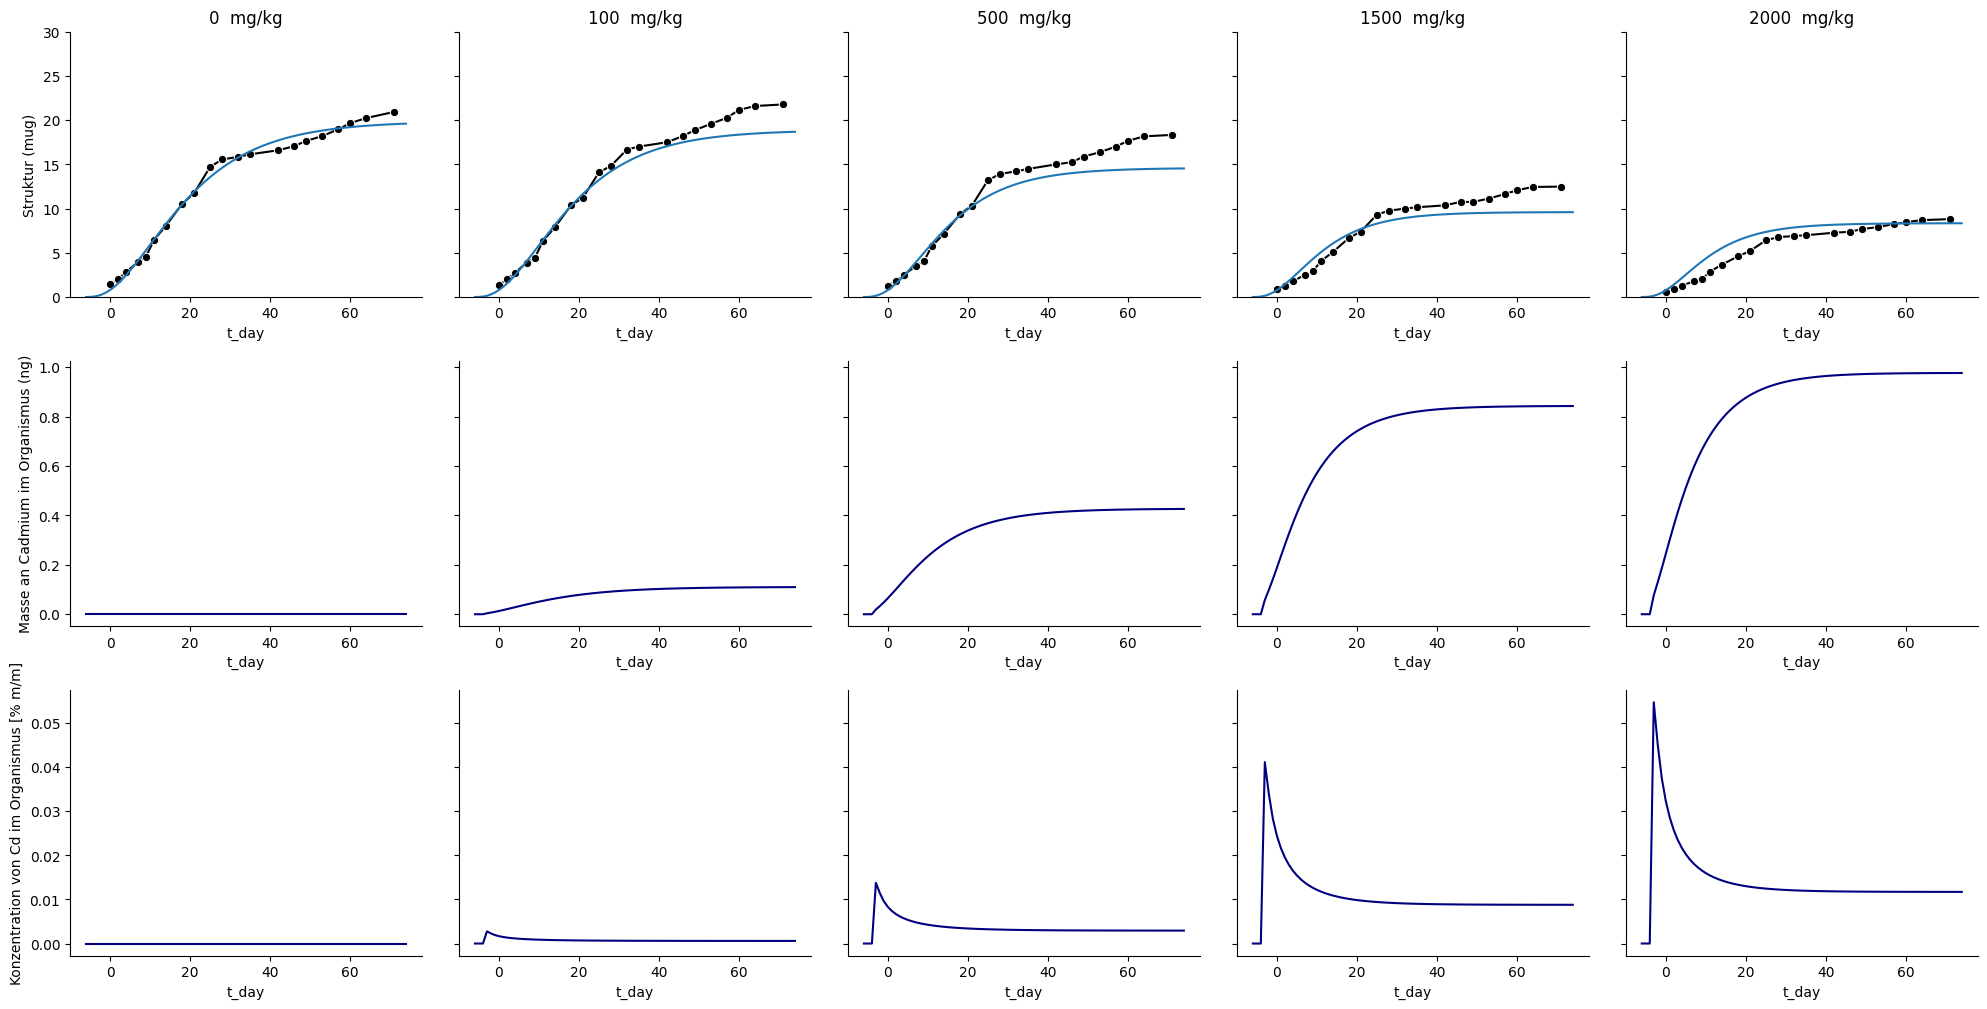

In [73]:
## maxiter 100

f = setup_modelfit(pmoa = 'A', func = simulate_DEBBase_cd_export)
f.defaultparams.spc.update(control_fitted_params)
f.intguess = {
        'ex_cd': 1,
        'ED50_j' : 1, 
        'beta_j' : 2, 
        }
sim = f.run_optimization(options={'maxiter' : 100} ) # führe Kalibrierung mittels lokaler Optimisierung durch

print(f"Estimated parameter values: {f.p_opt}")
# Simulation optimisierter Parameter
p = deepcopy(f.defaultparams)
p.spc.update(f.p_opt)  
sim_opt = f.simulator(p.spc)

# Visual predictive check

fig, ax = plot_data(f.data)
ax = plot_sim(ax, sim_opt)

Fitted model using Nelder-Mead method. Results stored in `optimization_result`
Estimated parameter values: {'ex_cd': np.float64(74.8170079842406), 'ED50_j': np.float64(0.27383397015963706), 'beta_j': np.float64(1.3947353614674718)}


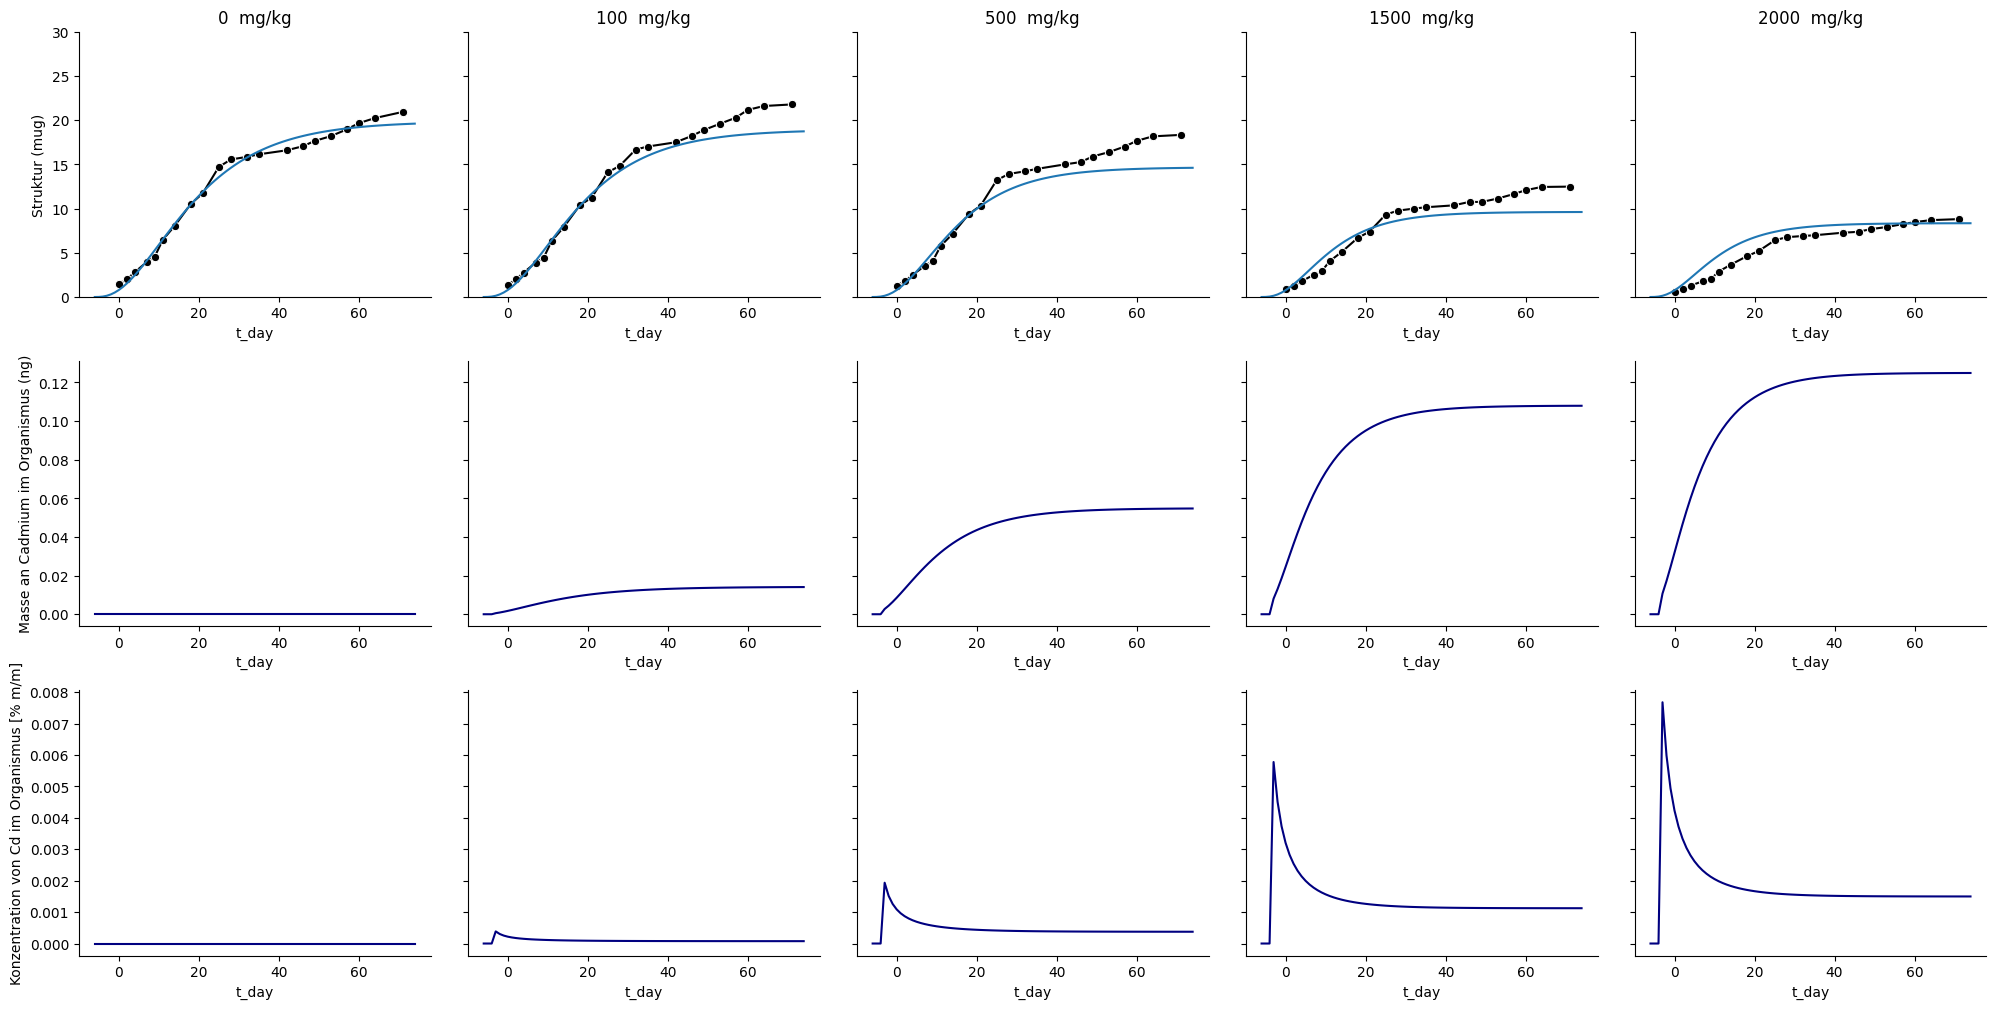

In [74]:
## no maxiter 

f = setup_modelfit(pmoa = 'A', func = simulate_DEBBase_cd_export)
f.defaultparams.spc.update(control_fitted_params)
f.intguess = {
        'ex_cd': 1,
        'ED50_j' : 1, 
        'beta_j' : 2, 
        }
sim = f.run_optimization() # führe Kalibrierung mittels lokaler Optimisierung durch

print(f"Estimated parameter values: {f.p_opt}")
# Simulation optimisierter Parameter
p = deepcopy(f.defaultparams)
p.spc.update(f.p_opt)  
sim_opt_A_full = f.simulator(p.spc)

# Visual predictive check

fig, ax = plot_data(f.data)
ax = plot_sim(ax, sim_opt_A_full)

## run time 19:52
## Estimated parameter values: {'ex_cd': np.float64(74.8170079842406), 'ED50_j': np.float64(0.27383397015963706), 'beta_j': np.float64(1.3947353614674718)}

In [67]:
f = setup_modelfit(pmoa = 'A', func = simulate_DEBBase_cd_export)
f.defaultparams.spc.update(control_fitted_params)

intguess = {'ex_cd': np.float64(74.8170079842406), 'ED50_j': np.float64(0.27383397015963706), 'beta_j': np.float64(1.3947353614674718)}

sim3 = f.simulator(intguess)

loss = f.loss(sim3, f.data)
loss

np.float64(0.022959059803228588)

In [19]:
p = deepcopy(f.defaultparams)
p.spc.update(f.p_opt)  
sim_opt_A_full = f.simulator(p.spc)
sim_opt_A_full

,t_day,C_W,level_2,S,R,X_emb,X,Cd_in,cum_repro,cd_conc,S_ref,R_ref,X_emb_ref,X_ref,Cd_in_ref,C_W_ref,cum_repro_ref,cd_conc_ref,y_S
0,-6,0,0,0.000010,0.000000,9.924165e-01,1.000000e+10,0.000000,0.0,0.000000,0.00001,0.000000,0.992416,1.000000e+10,0.0,0,0.0,0.0,1.000000
1,-6,100,81,0.000010,0.000000,9.924165e-01,1.000000e+10,0.000000,48.0,0.000000,0.00001,0.000000,0.992416,1.000000e+10,0.0,0,0.0,0.0,1.000000
2,-6,500,162,0.000010,0.000000,9.924165e-01,1.000000e+10,0.000000,45.0,0.000000,0.00001,0.000000,0.992416,1.000000e+10,0.0,0,0.0,0.0,1.000000
3,-6,1500,243,0.000010,0.000000,9.924165e-01,1.000000e+10,0.000000,29.0,0.000000,0.00001,0.000000,0.992416,1.000000e+10,0.0,0,0.0,0.0,1.000000
4,-6,2000,324,0.000010,0.000000,9.924165e-01,1.000000e+10,0.000000,0.0,0.000000,0.00001,0.000000,0.992416,1.000000e+10,0.0,0,0.0,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,74,0,80,19.598500,48.949572,-1.128662e-05,7.831235e+11,0.000000,47.0,0.000000,19.59850,48.949572,-0.000011,7.831235e+11,0.0,0,47.0,0.0,1.000000
401,74,100,161,18.727711,46.431154,-1.337170e-05,7.831235e+11,0.014067,44.0,0.000751,19.59850,48.949572,-0.000011,7.831235e+11,0.0,0,47.0,0.0,0.955569
402,74,500,242,14.605715,29.706447,-6.300240e-07,7.831236e+11,0.054743,28.0,0.003748,19.59850,48.949572,-0.000011,7.831235e+11,0.0,0,47.0,0.0,0.745247
403,74,1500,323,9.608301,0.000000,-9.526530e-08,7.831236e+11,0.107926,0.0,0.011233,19.59850,48.949572,-0.000011,7.831235e+11,0.0,0,47.0,0.0,0.490257


### Modelfitting for PMoA: M

Fitted model using Nelder-Mead method. Results stored in `optimization_result`
Estimated parameter values: {'ex_cd': np.float64(1.0), 'ED50_j': np.float64(1.05), 'beta_j': np.float64(2.0)}


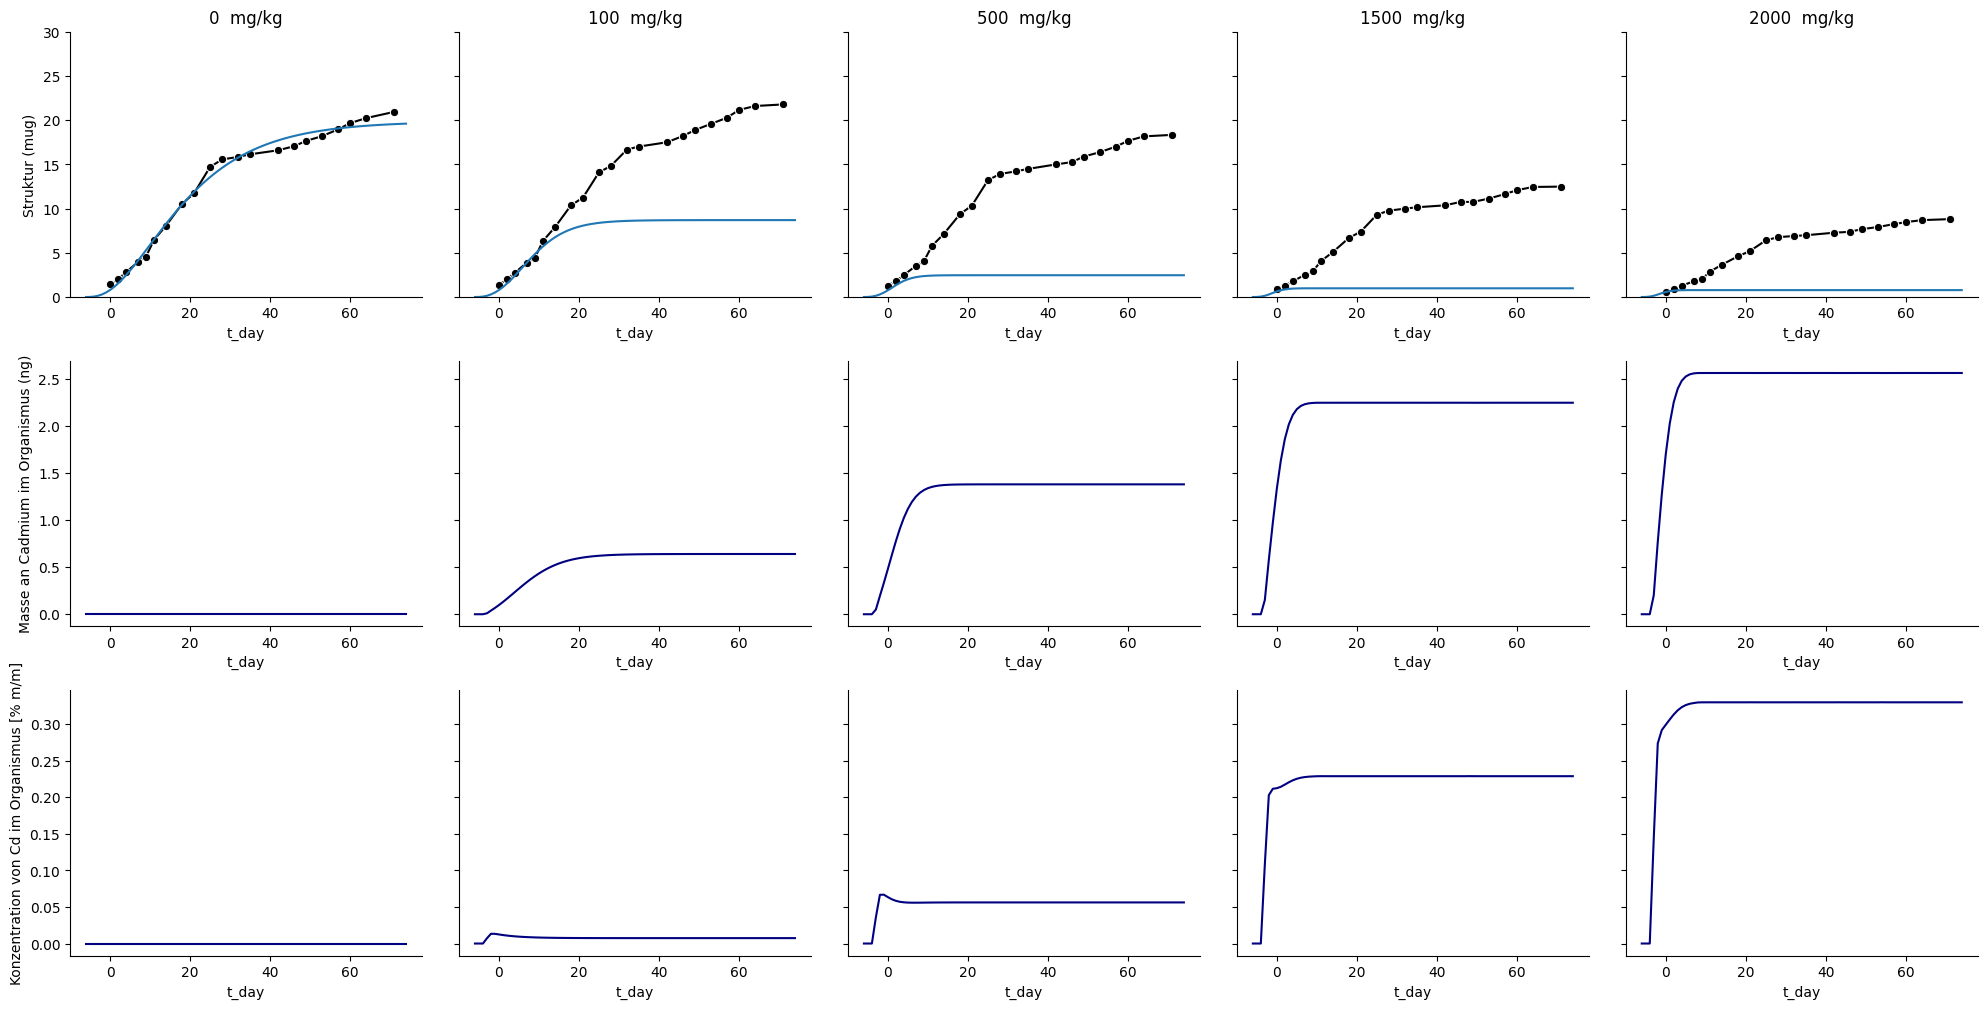

In [76]:
## maxiter 1

f = setup_modelfit(pmoa = 'M', func = simulate_DEBBase_cd_export)
f.defaultparams.spc.update(control_fitted_params)
f.intguess = {
        'ex_cd': 1,
        'ED50_j' : 1, 
        'beta_j' : 2, 
        }
sim = f.run_optimization(options={'maxiter' : 1} ) # führe Kalibrierung mittels lokaler Optimisierung durch

print(f"Estimated parameter values: {f.p_opt}")
# Simulation optimisierter Parameter
p = deepcopy(f.defaultparams)
p.spc.update(f.p_opt)  
sim_opt = f.simulator(p.spc)

# Visual predictive check

fig, ax = plot_data(f.data)
ax = plot_sim(ax, sim_opt)

Fitted model using Nelder-Mead method. Results stored in `optimization_result`
Estimated parameter values: {'ex_cd': np.float64(1.210905349794238), 'ED50_j': np.float64(11.987654320987652), 'beta_j': np.float64(3.8703703703703702)}


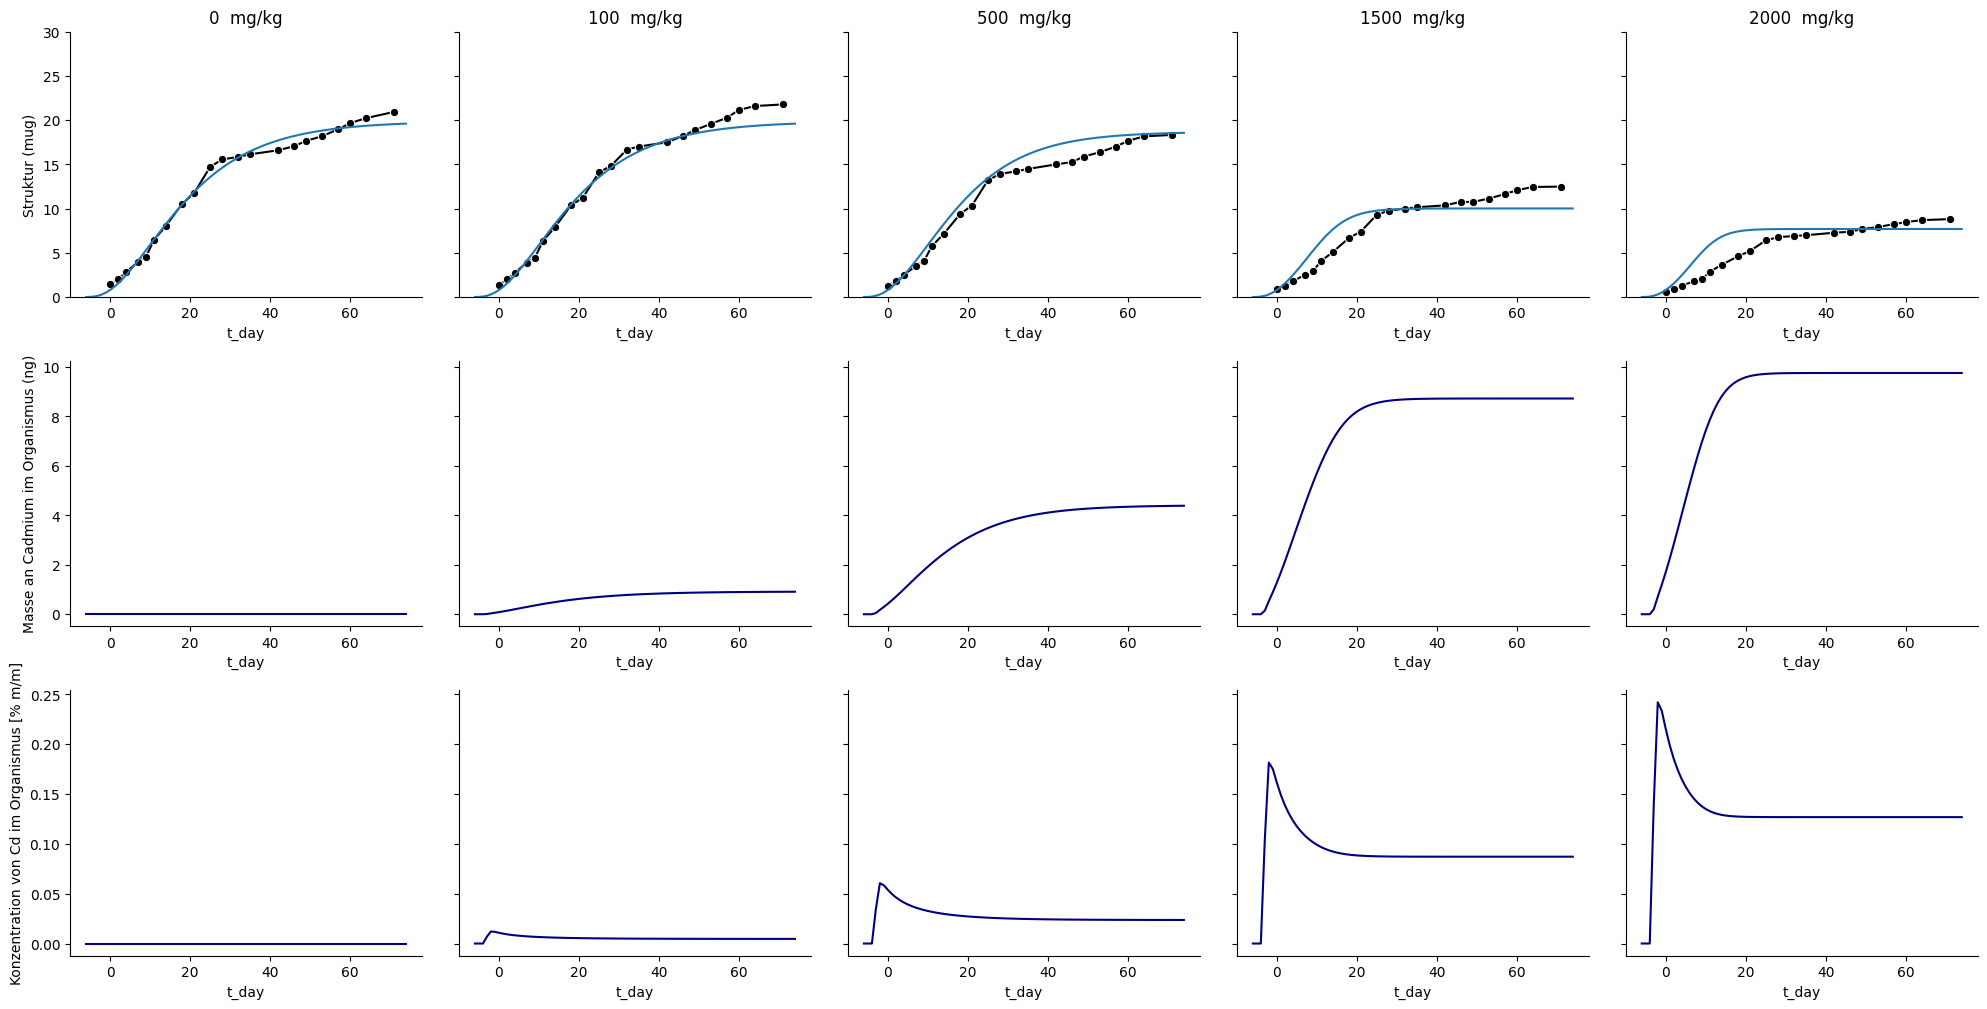

In [78]:
## maxiter 10

f = setup_modelfit(pmoa = 'M', func = simulate_DEBBase_cd_export)
f.defaultparams.spc.update(control_fitted_params)
f.intguess = {
        'ex_cd': 1,
        'ED50_j' : 10, 
        'beta_j' : 5, 
        }
sim = f.run_optimization(bounds = [(0, 1000), (0, 1000), (0, 1000)],
    options={'maxiter' : 10} ) # führe Kalibrierung mittels lokaler Optimisierung durch

print(f"Estimated parameter values: {f.p_opt}")
# Simulation optimisierter Parameter
p = deepcopy(f.defaultparams)
p.spc.update(f.p_opt)  
sim_opt = f.simulator(p.spc)

# Visual predictive check

fig, ax = plot_data(f.data)
ax = plot_sim(ax, sim_opt)

Fitted model using Nelder-Mead method. Results stored in `optimization_result`
Estimated parameter values: {'ex_cd': np.float64(2.6341271401774895), 'ED50_j': np.float64(8.259561974862052), 'beta_j': np.float64(1.4413902830130123)}


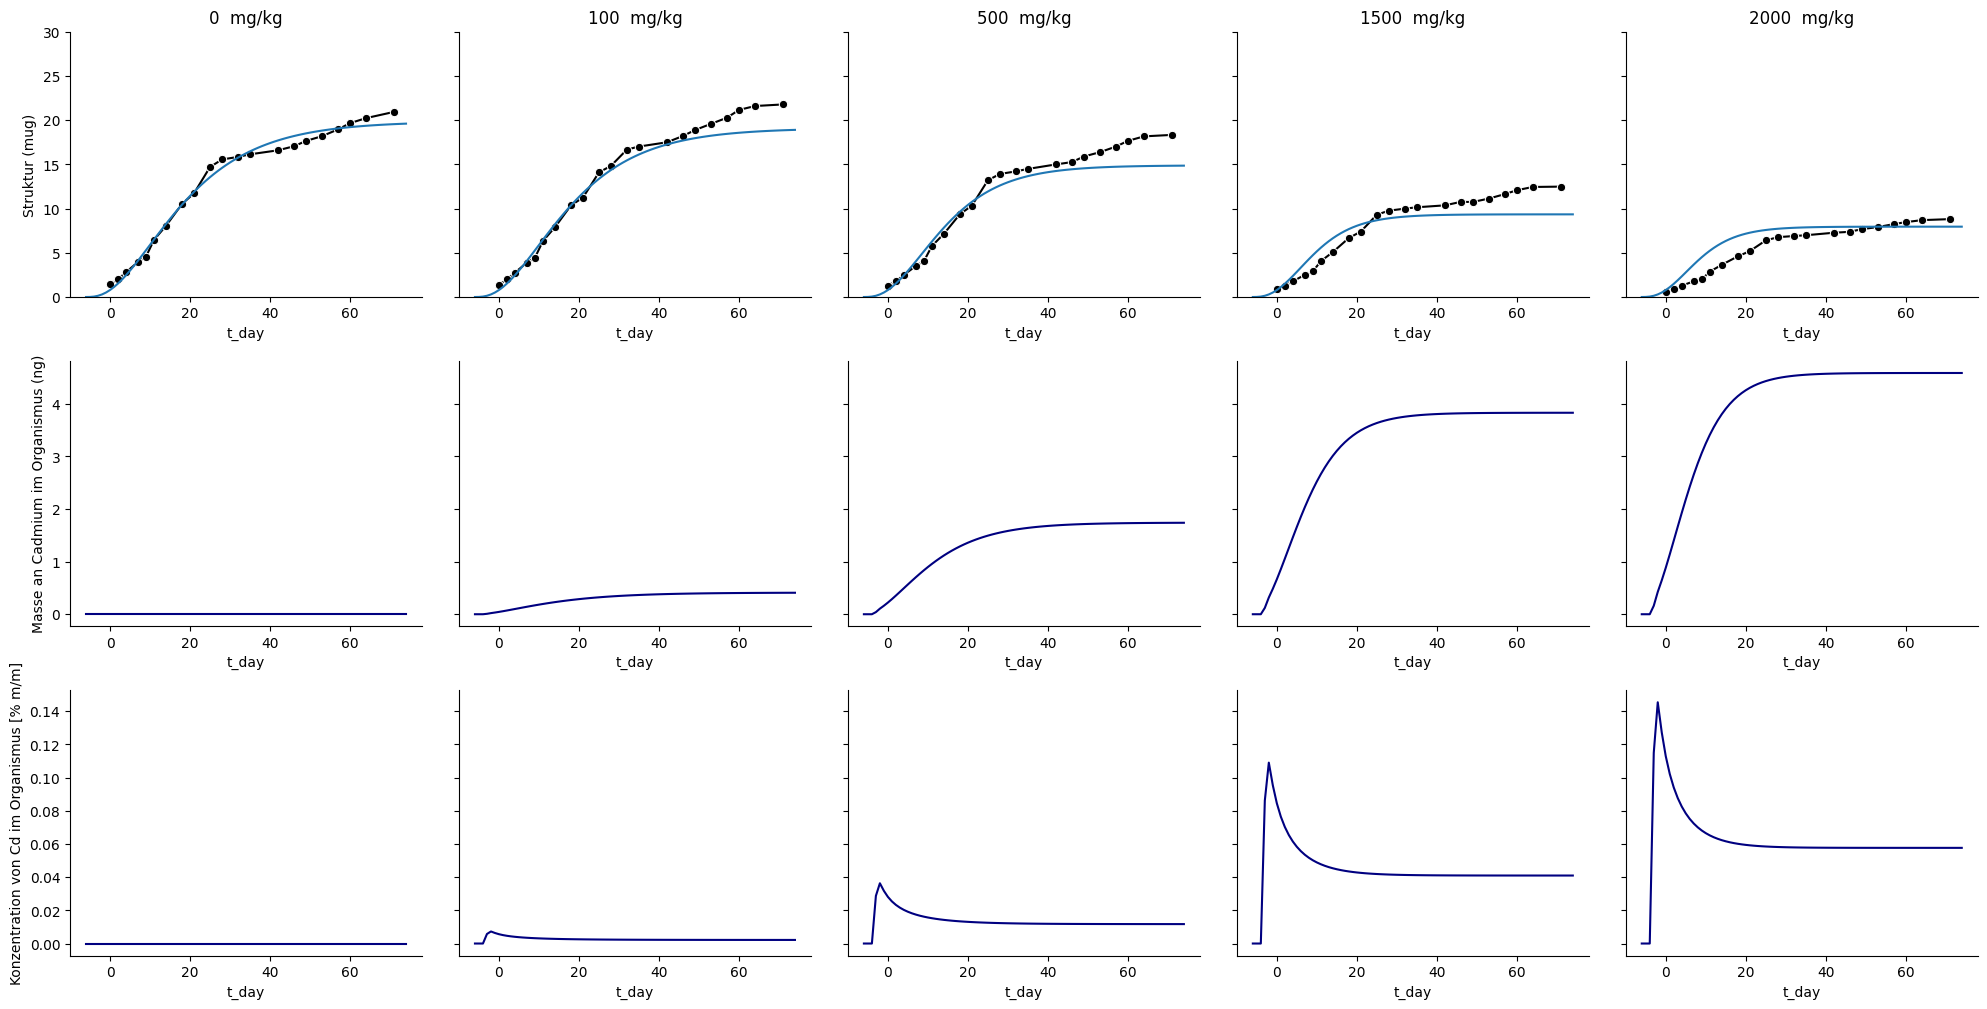

In [80]:
## maxiter 100

f = setup_modelfit(pmoa = 'M', func = simulate_DEBBase_cd_export)
f.defaultparams.spc.update(control_fitted_params)
f.intguess = {
        'ex_cd': 1,
        'ED50_j' : 10, 
        'beta_j' : 5,  
        }
sim = f.run_optimization(bounds = [(0, 1000), (0, 1000), (0, 1000)],
    options={'maxiter' : 100} ) # führe Kalibrierung mittels lokaler Optimisierung durch

print(f"Estimated parameter values: {f.p_opt}")
# Simulation optimisierter Parameter
p = deepcopy(f.defaultparams)
p.spc.update(f.p_opt)  
sim_opt_G_100 = f.simulator(p.spc)

# Visual predictive check

fig, ax = plot_data(f.data)
ax = plot_sim(ax, sim_opt_G_100)

Fitted model using Nelder-Mead method. Results stored in `optimization_result`
Estimated parameter values: {'ex_cd': np.float64(32.5624330345066), 'ED50_j': np.float64(0.6599869050139842), 'beta_j': np.float64(1.4869993936853216)}


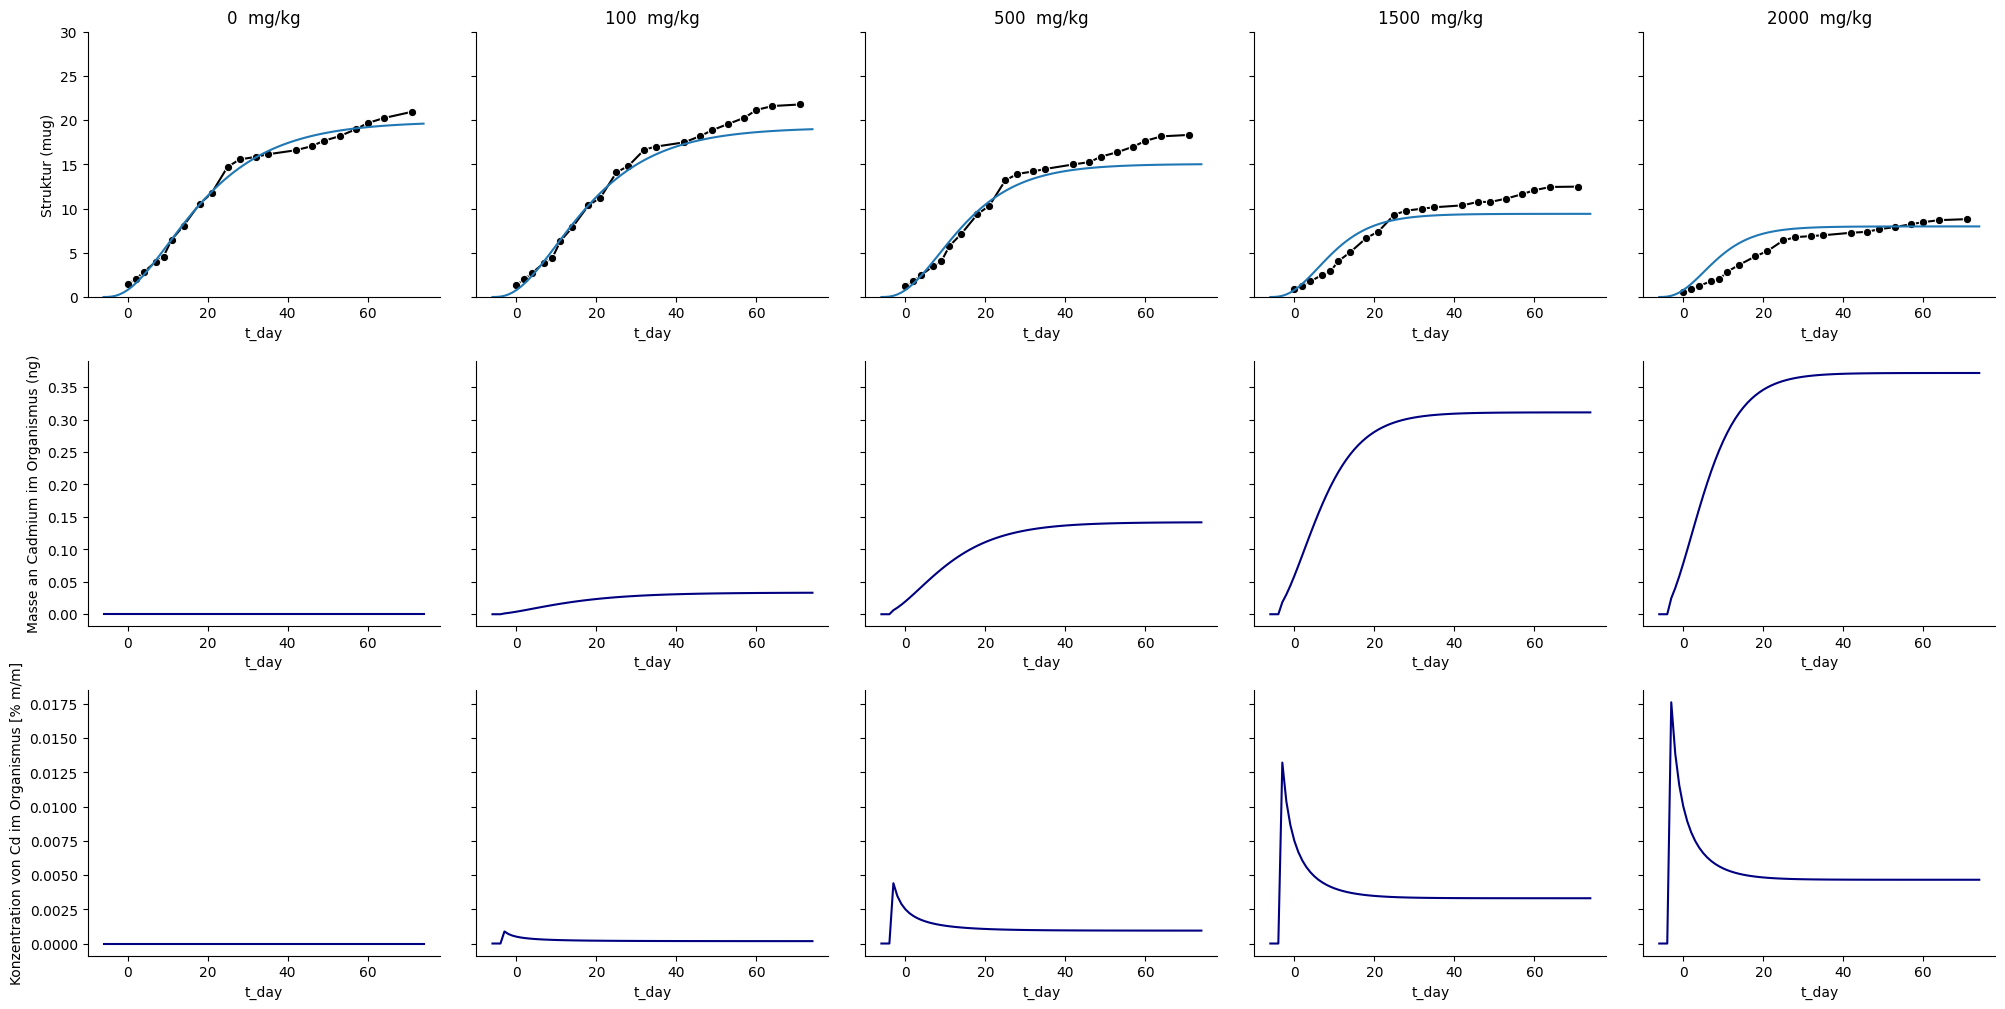

In [81]:
## no maxiter 

f = setup_modelfit(pmoa = 'M', func = simulate_DEBBase_cd_export)
f.defaultparams.spc.update(control_fitted_params)
f.intguess = {
        'ex_cd': 1,
        'ED50_j' : 10, 
        'beta_j' : 5,  
        }
sim = f.run_optimization(bounds = [(0, 1000), (0, 1000), (0, 1000)]) # führe Kalibrierung mittels lokaler Optimisierung durch

print(f"Estimated parameter values: {f.p_opt}")
# Simulation optimisierter Parameter
p = deepcopy(f.defaultparams)
p.spc.update(f.p_opt)  
sim_opt_G_full = f.simulator(p.spc)

# Visual predictive check

fig, ax = plot_data(f.data)
ax = plot_sim(ax, sim_opt_G_full)

### last run took 16:55 mins
## Estimated parameter values: {'ex_cd': np.float64(32.5624330345066), 'ED50_j': np.float64(0.6599869050139842), 'beta_j': np.float64(1.4869993936853216)}


In [68]:
f = setup_modelfit(pmoa = 'M', func = simulate_DEBBase_cd_export)
f.defaultparams.spc.update(control_fitted_params)

intguess = {'ex_cd': np.float64(32.5624330345066), 'ED50_j': np.float64(0.6599869050139842), 'beta_j': np.float64(1.4869993936853216)}

sim3 = f.simulator(intguess)

loss = f.loss(sim3, f.data)
loss



np.float64(0.02860387151536839)